In [4]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import periodogram
import GSR_analysis as GSR
import HRV_analysis as HRV
import numpy as np
import os
from scipy.stats import pearsonr
import warnings

warnings.filterwarnings('ignore')

In [5]:
#initialize feature names
stat_features_names_all = ['mean','std','skew','kurtosis','diff','diff2','q25','q75',
                           'qdev','max-min','coeff_var','d_mean','d_std','d_skew','d_kurtosis',
                           'd_diff','d_diff2','d_q25','d_q75','d_qdev','d_max-min','d_coeff_var']


feature_names = []

#generate a list with all features
for n in stat_features_names_all:
    feature_names.append('st_stat_'+n)
print(len(feature_names))      
for n in stat_features_names_all:
    feature_names.append('eda_stat_'+n)        
print(len(feature_names))        
for n in GSR.feature_names_all:
    feature_names.append('eda_'+n)
print(len(feature_names))
for n in stat_features_names_all:
    feature_names.append('hr_stat_'+n)        
print(len(feature_names))  

for n in HRV.feature_names_time:
    feature_names.append('rrHRV_'+n) 
feature_names.append('rrHRV__numRRs') 
feature_names.append('eda_st_corr')
len(feature_names)

22
44
85
107


119

file: 1mpau_sensors.csv


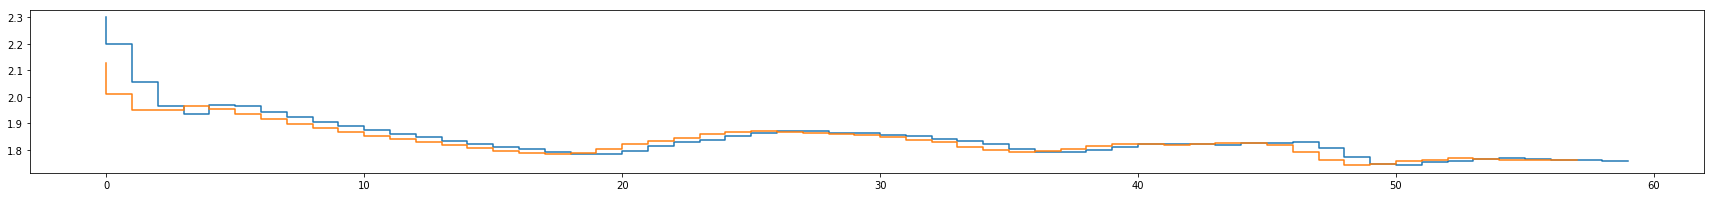

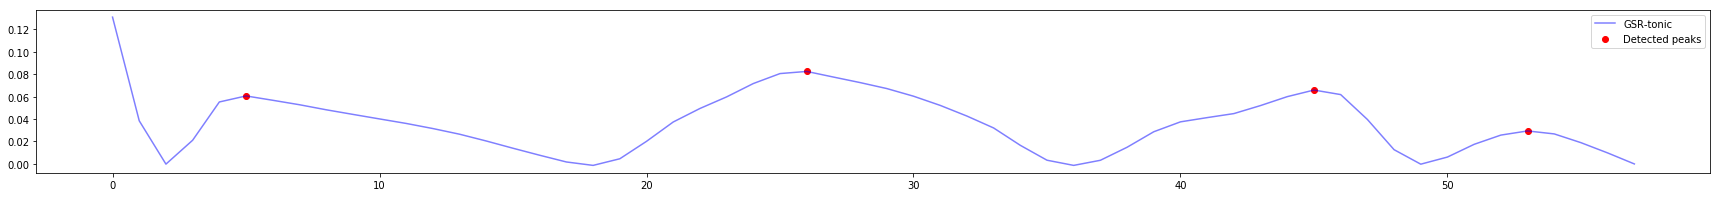

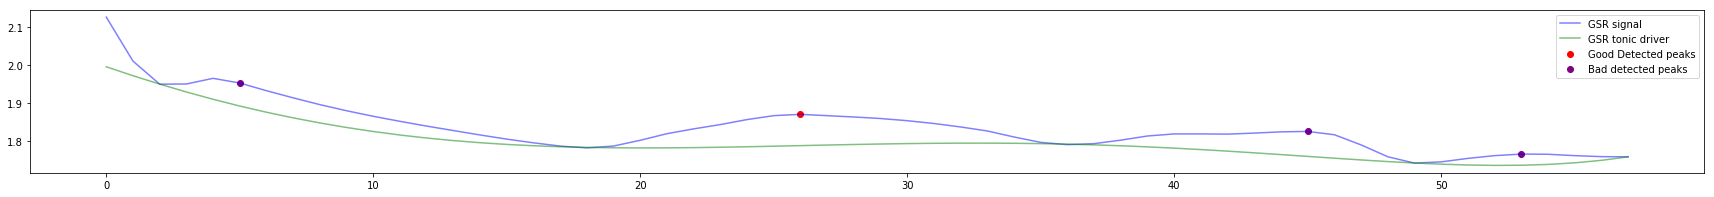

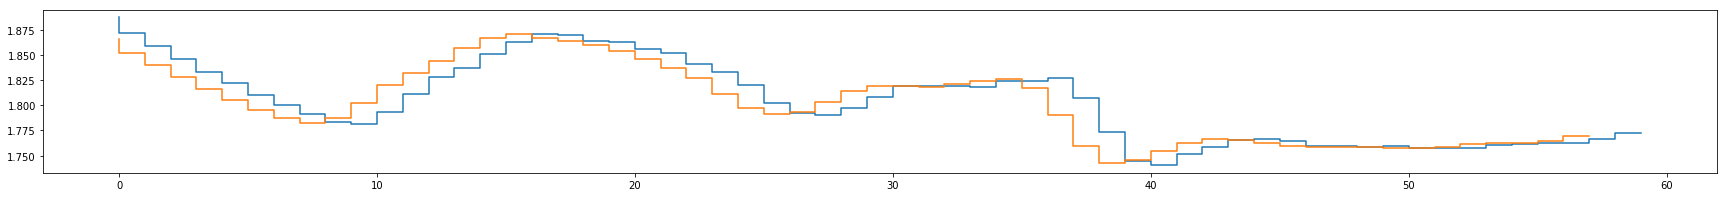

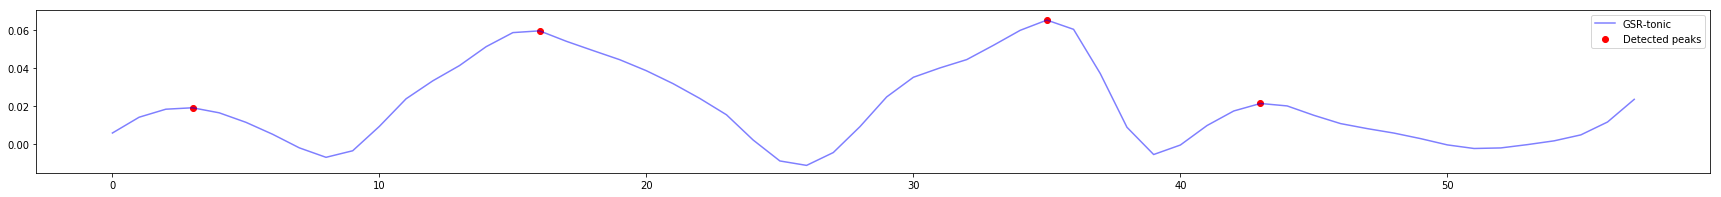

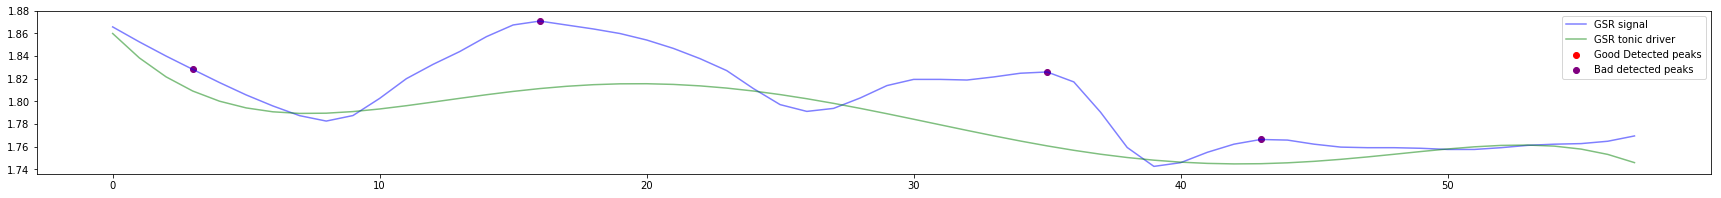

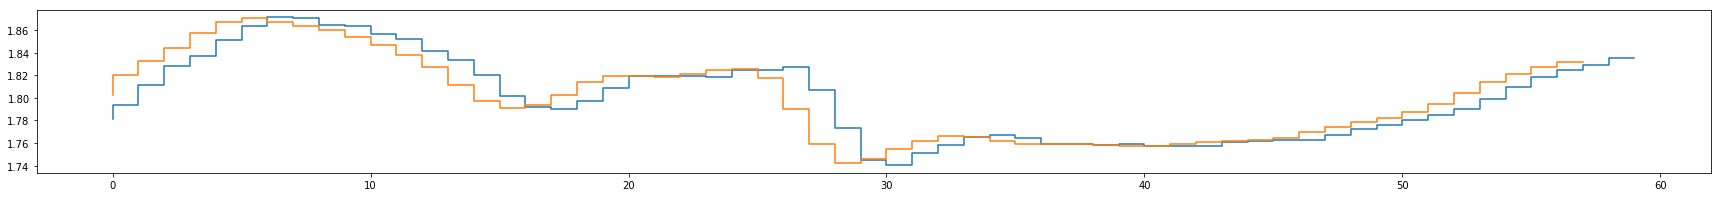

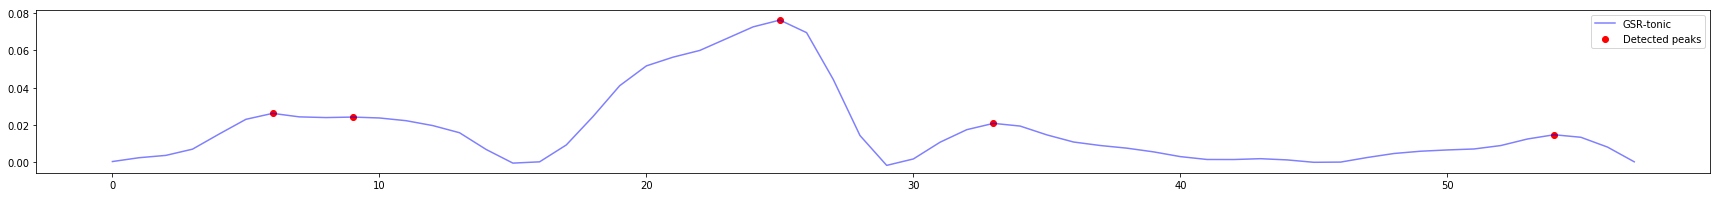

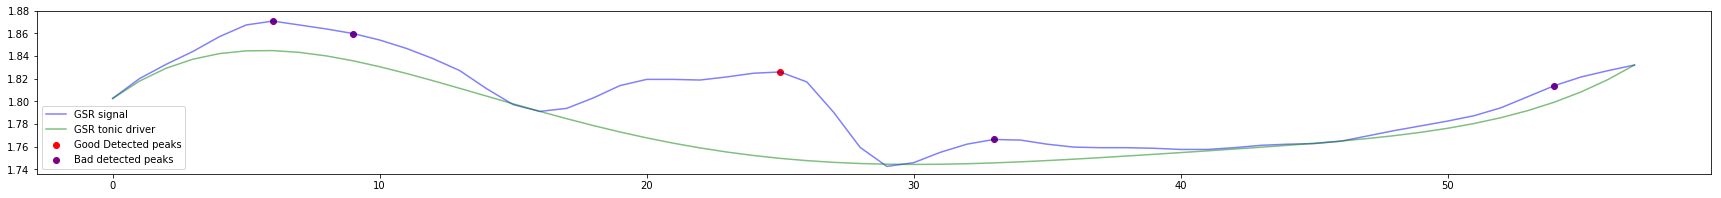

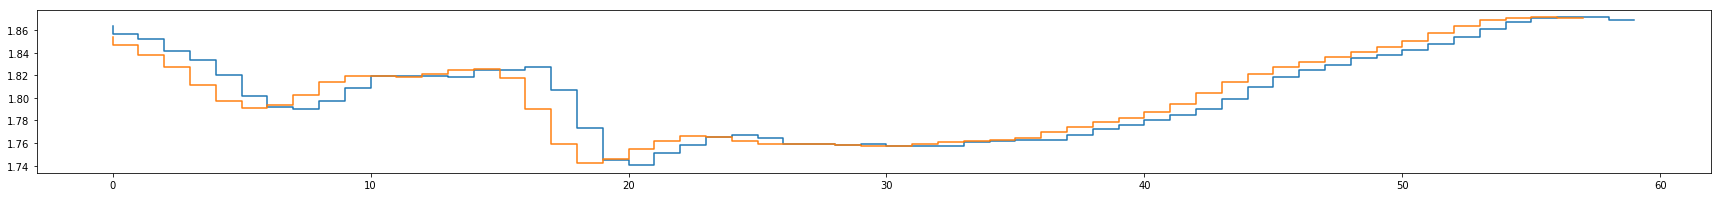

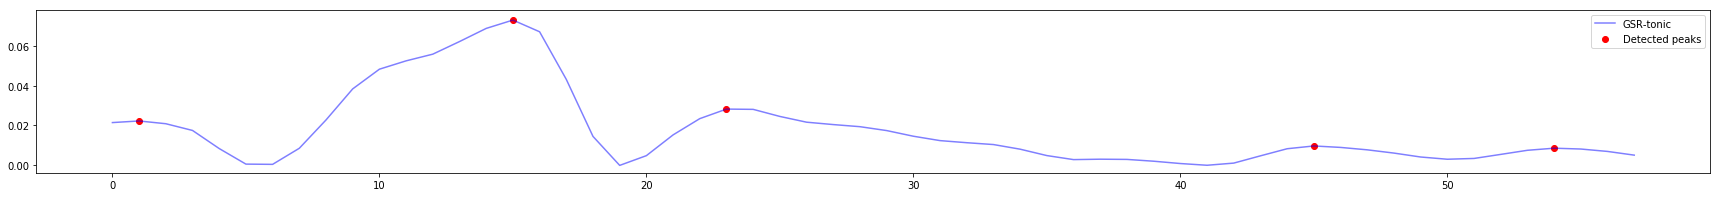

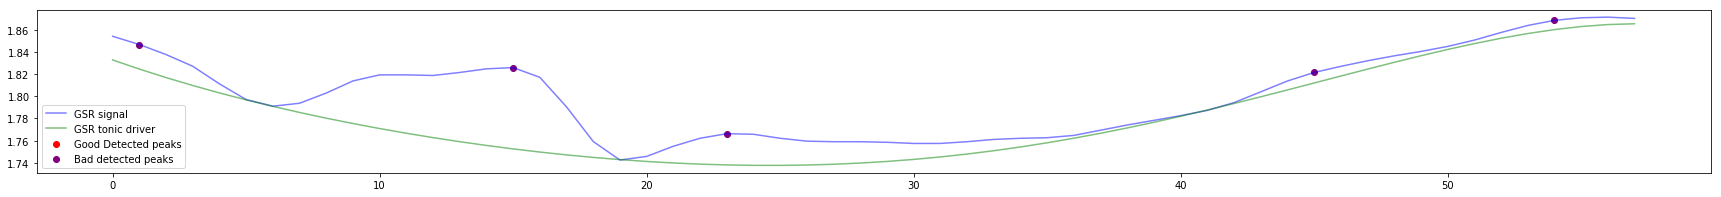

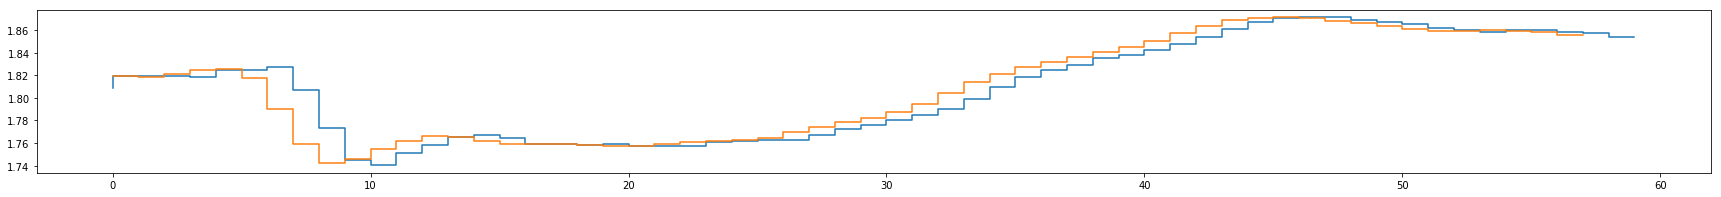

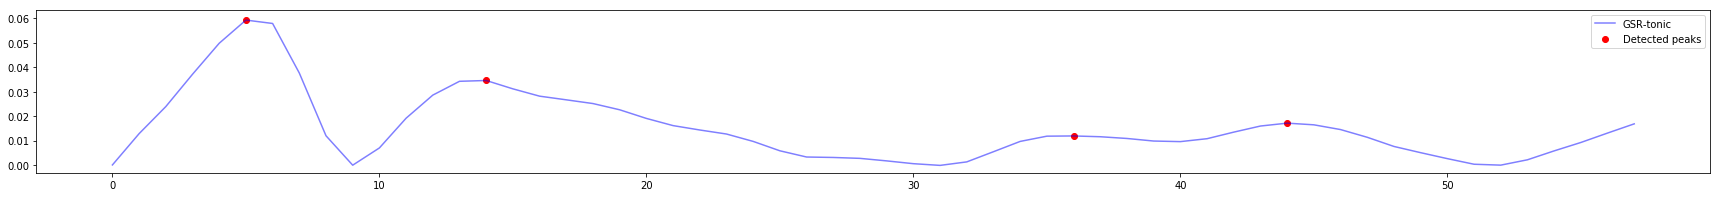

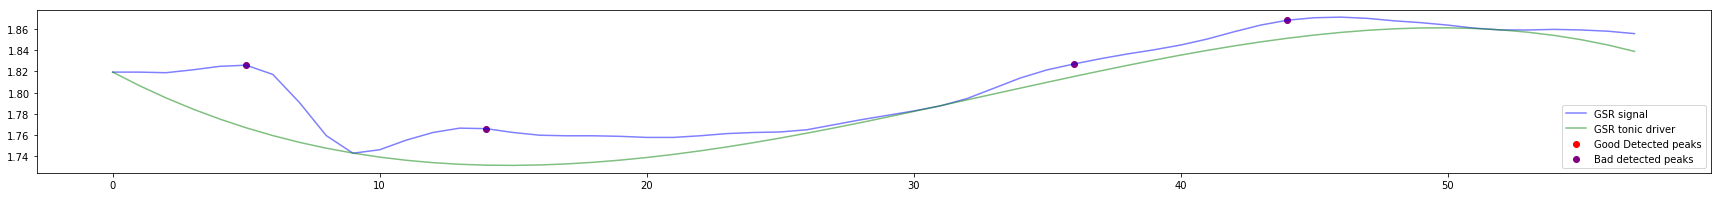

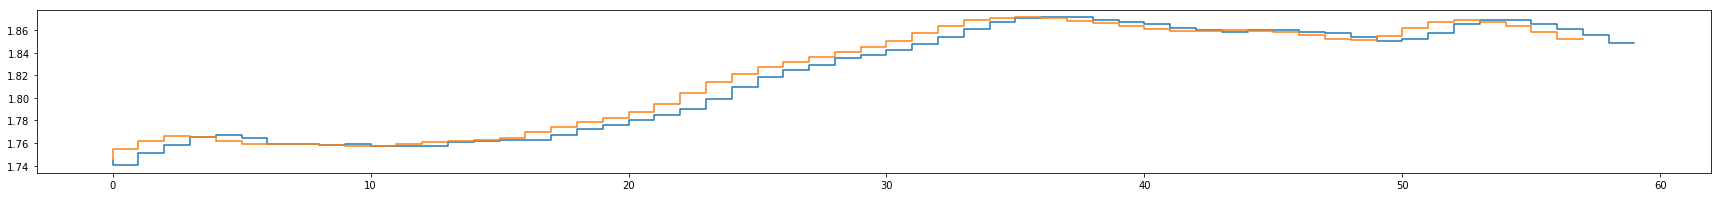

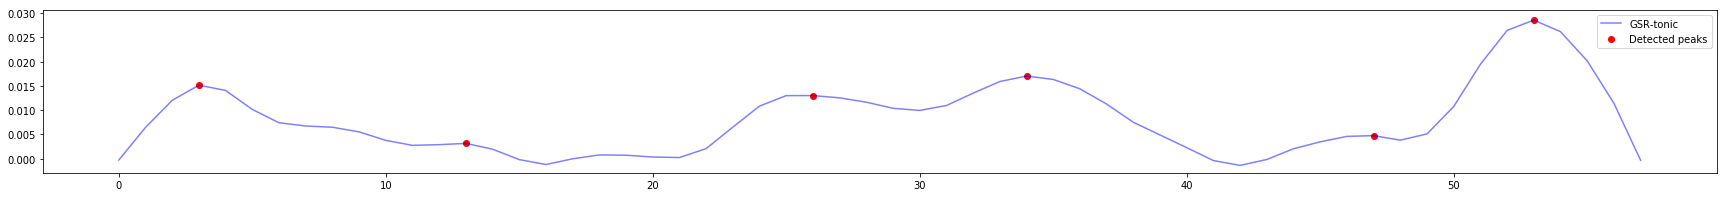

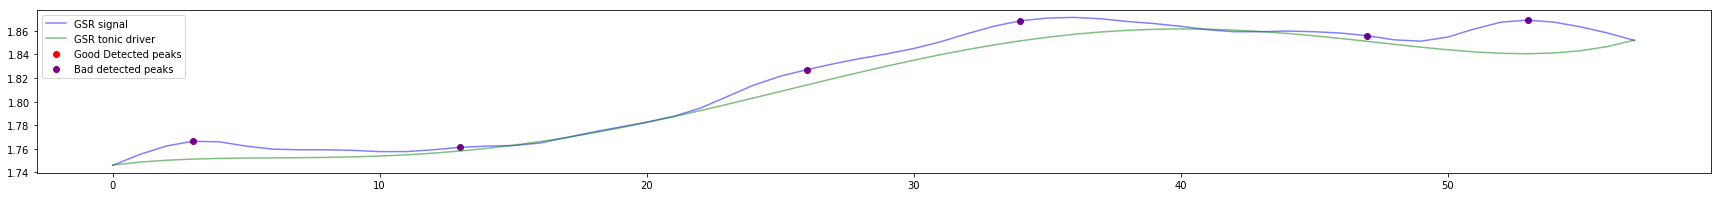

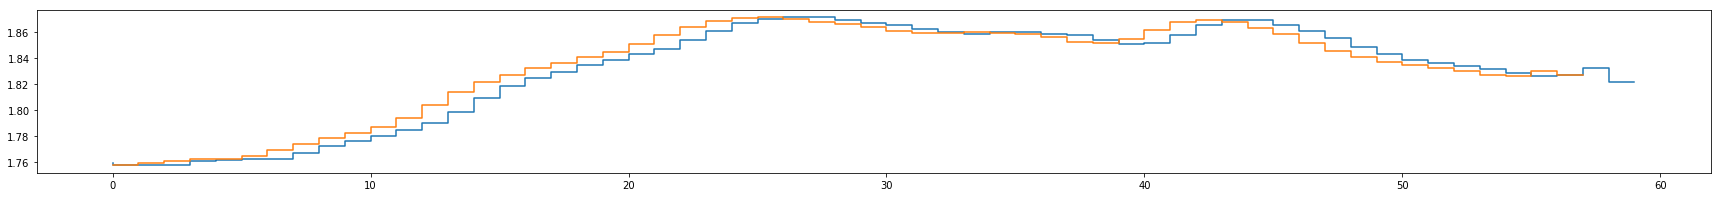

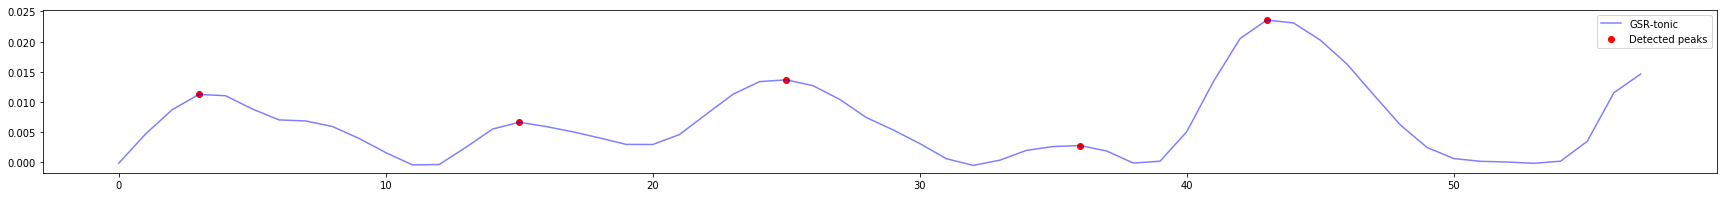

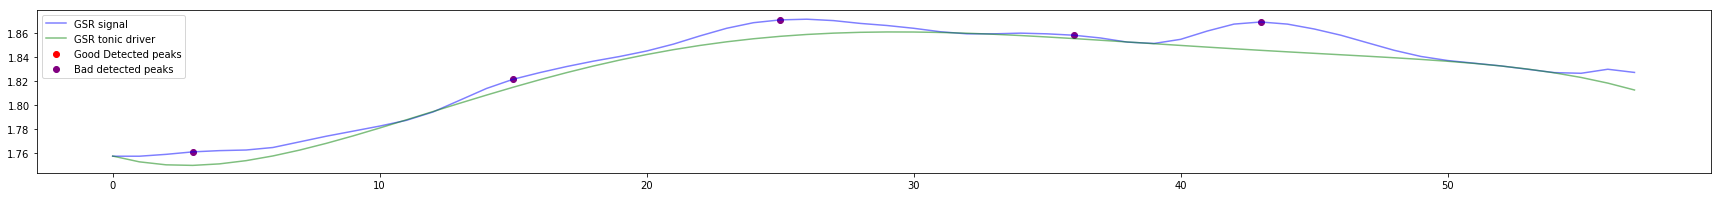

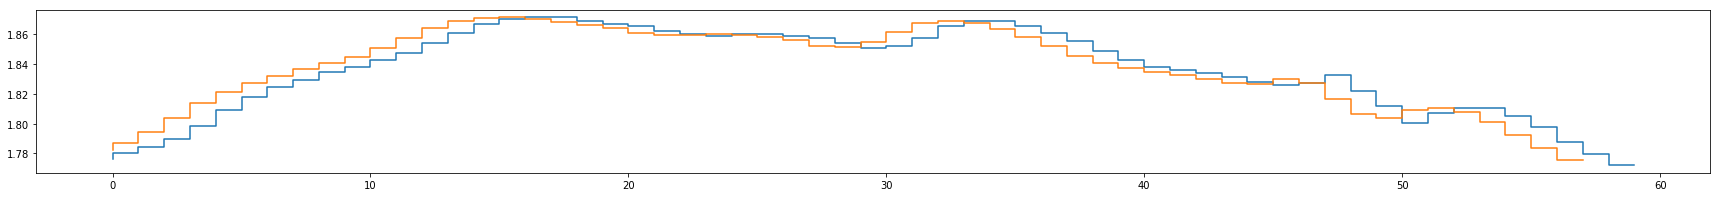

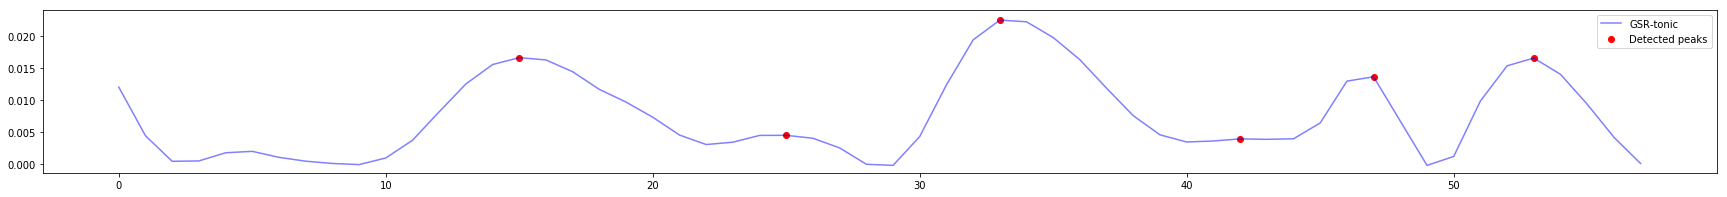

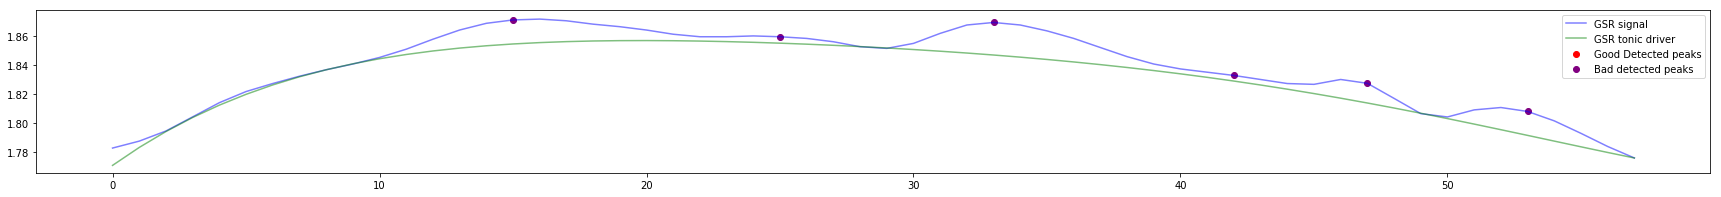

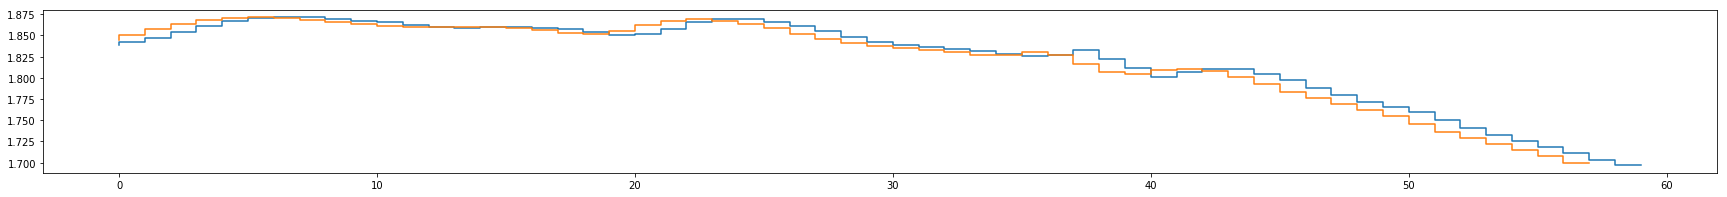

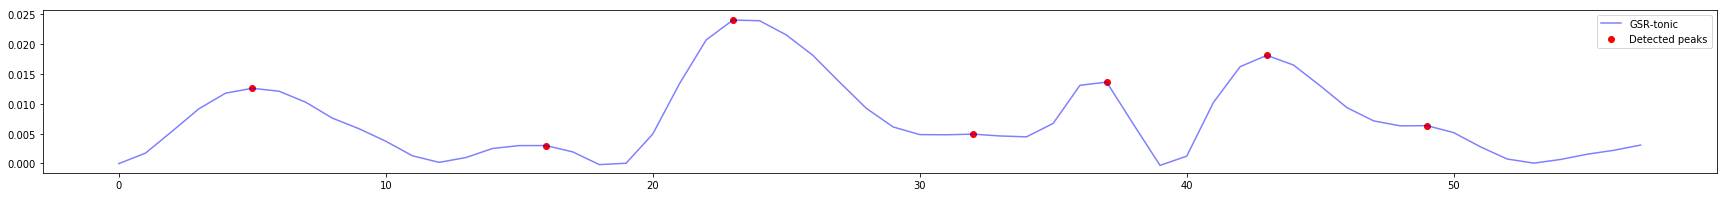

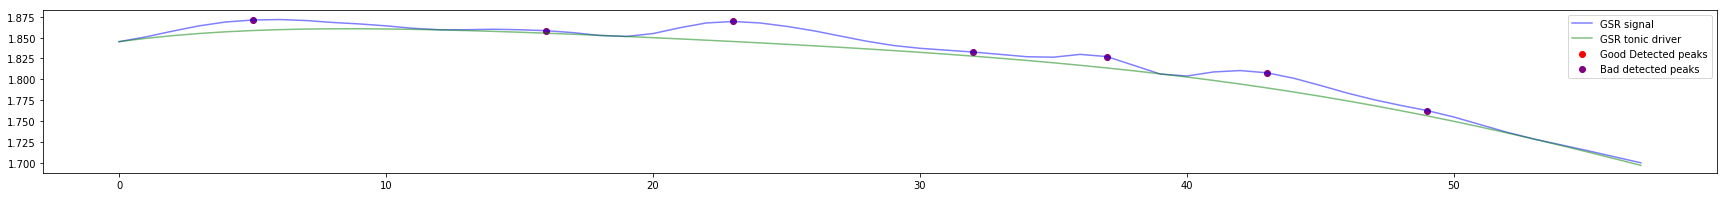

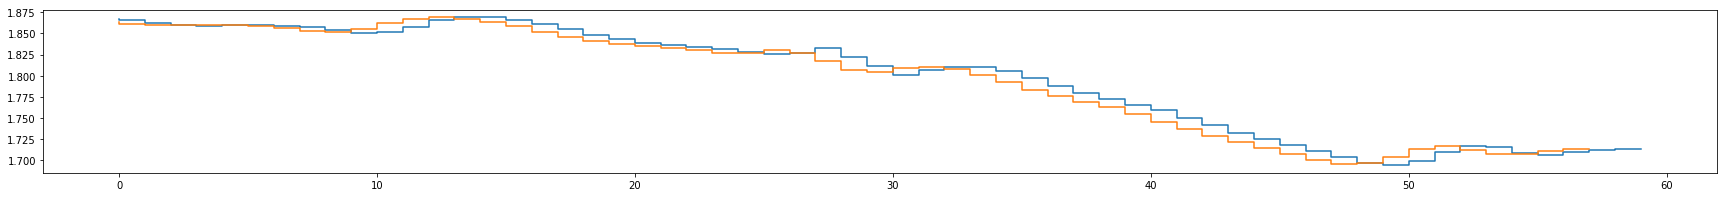

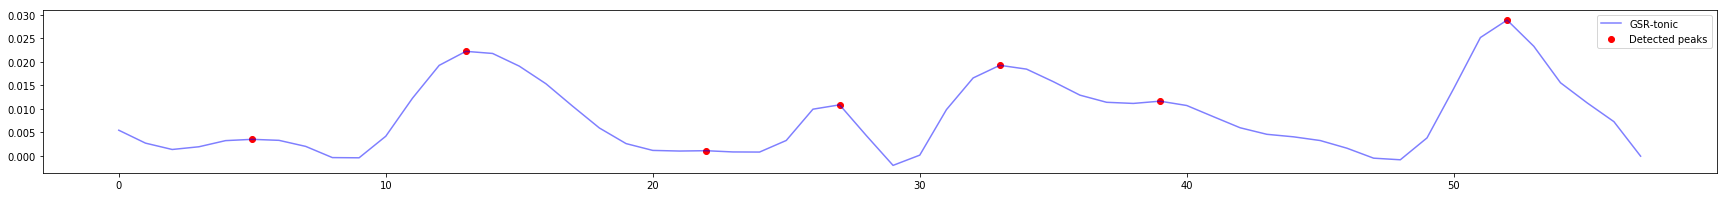

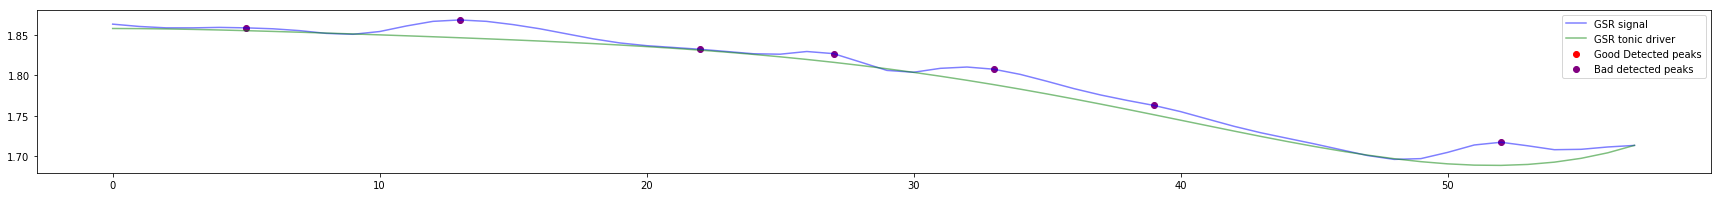

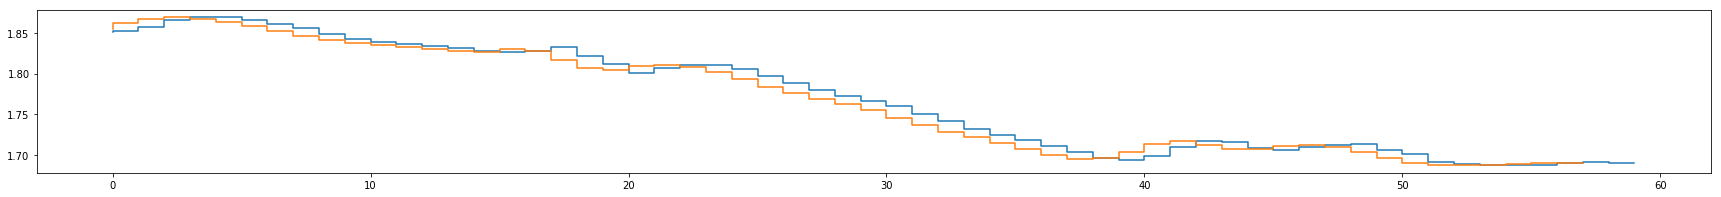

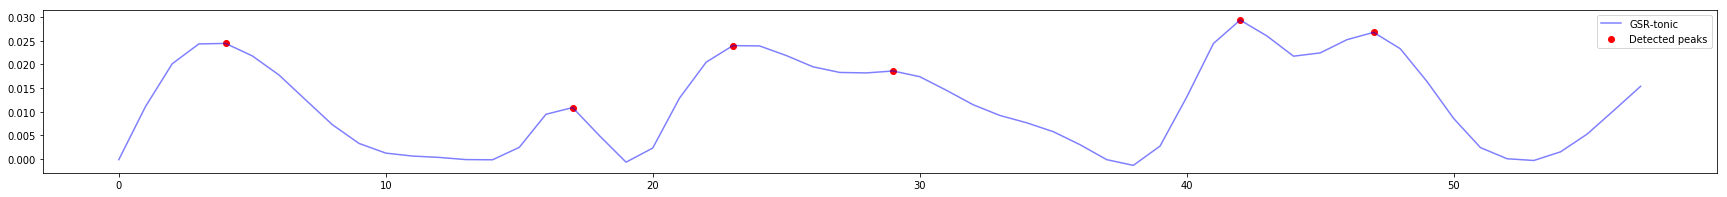

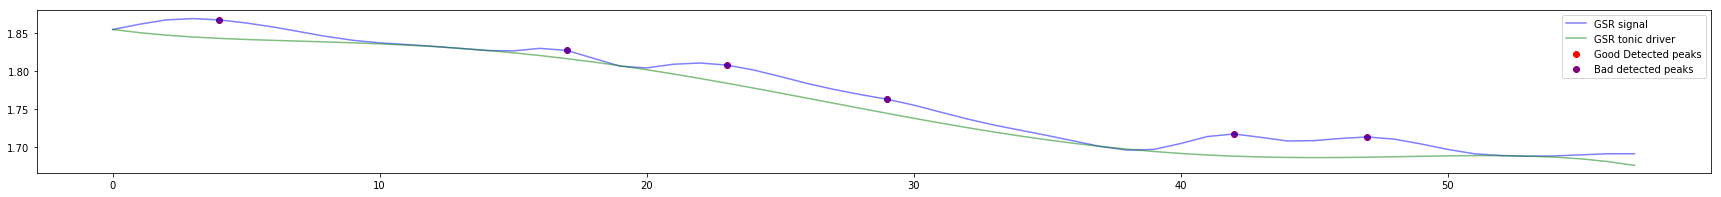

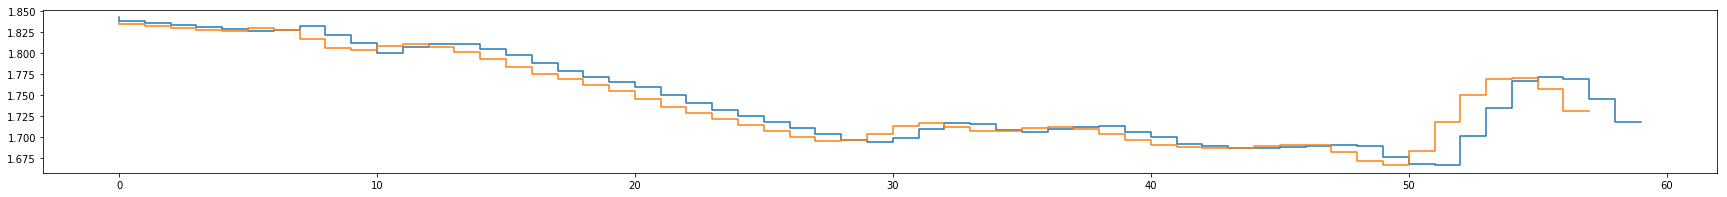

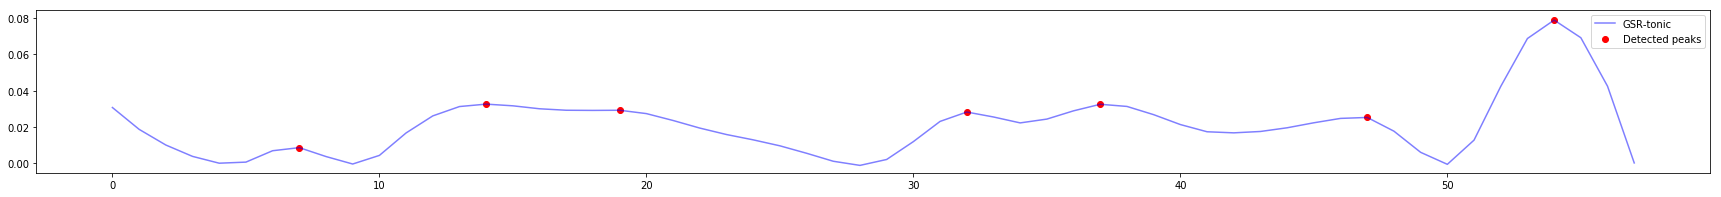

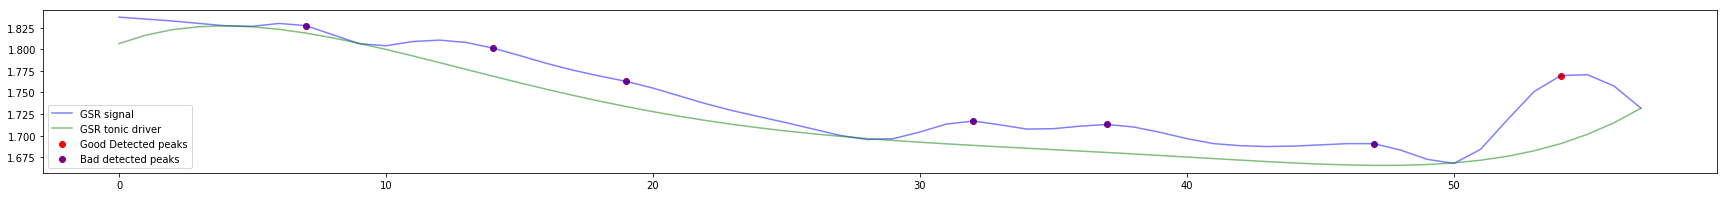

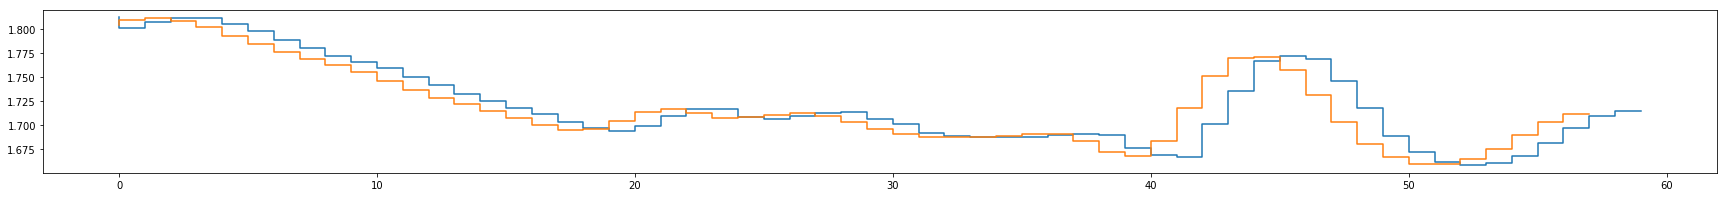

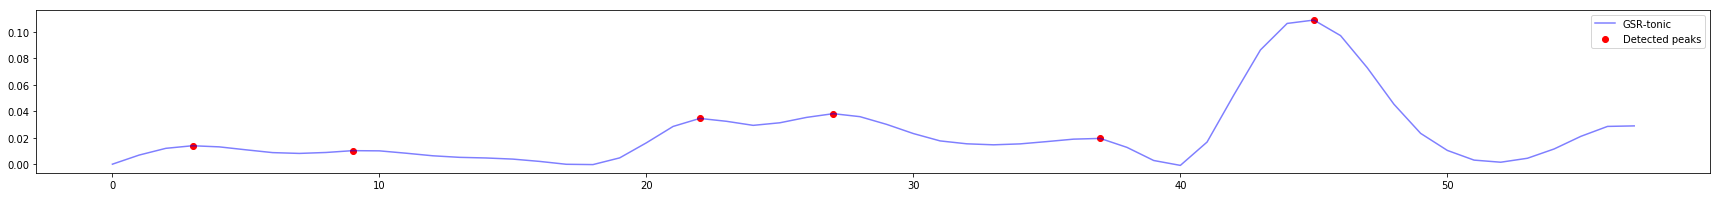

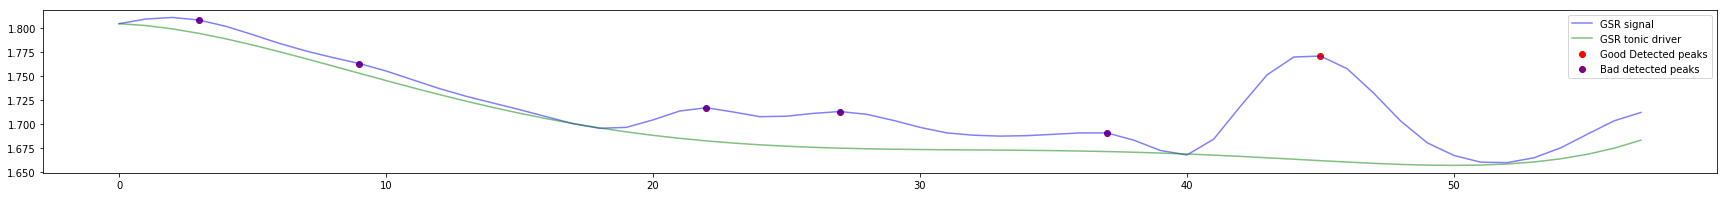

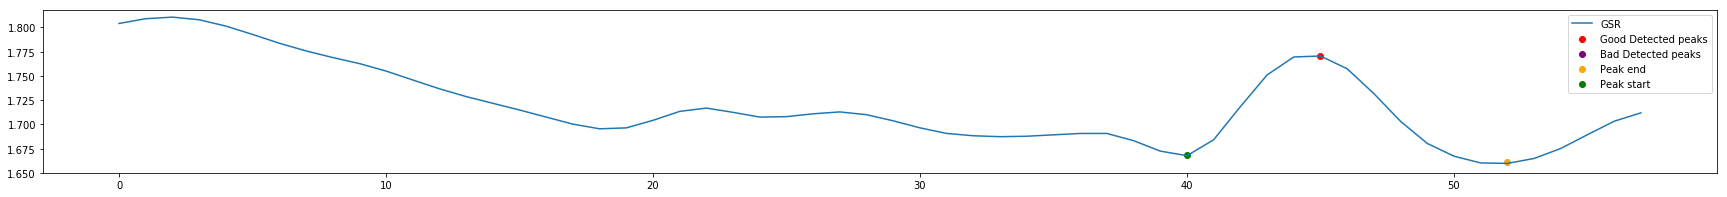

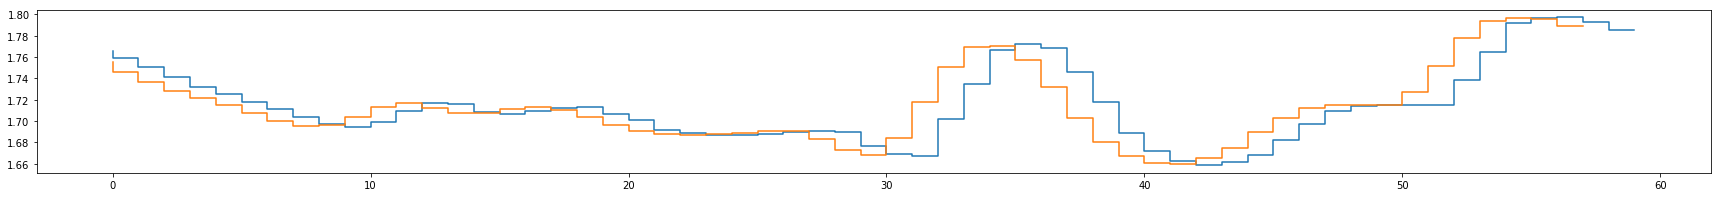

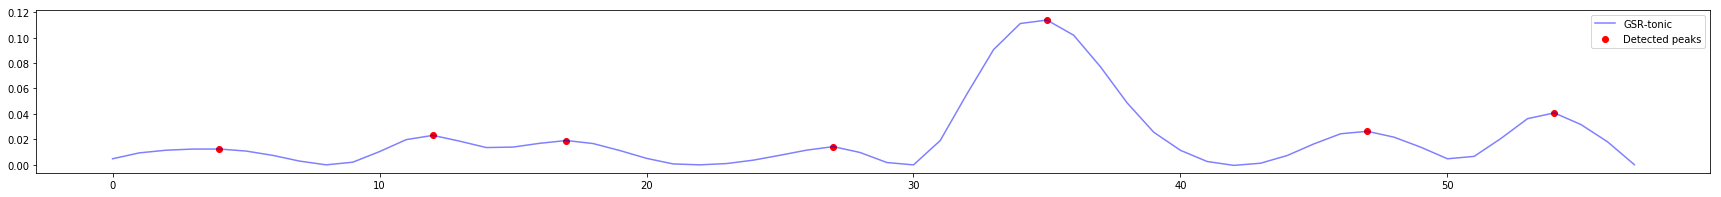

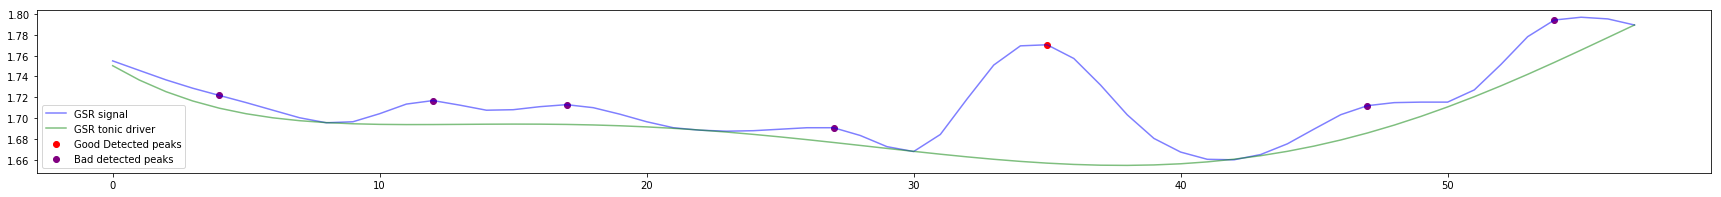

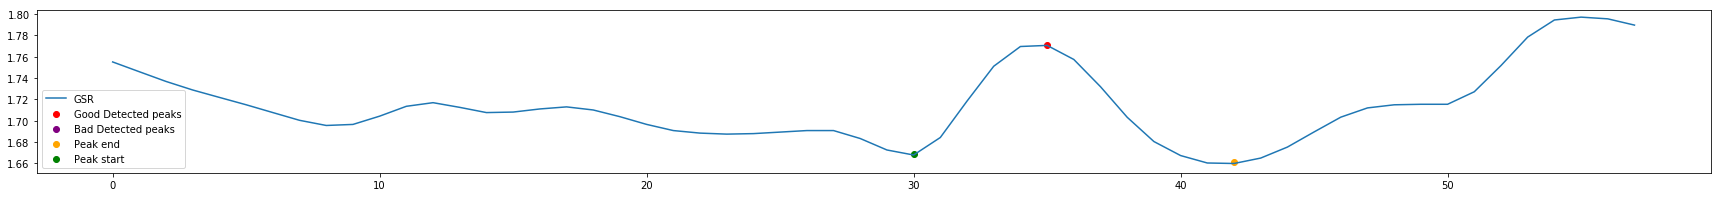

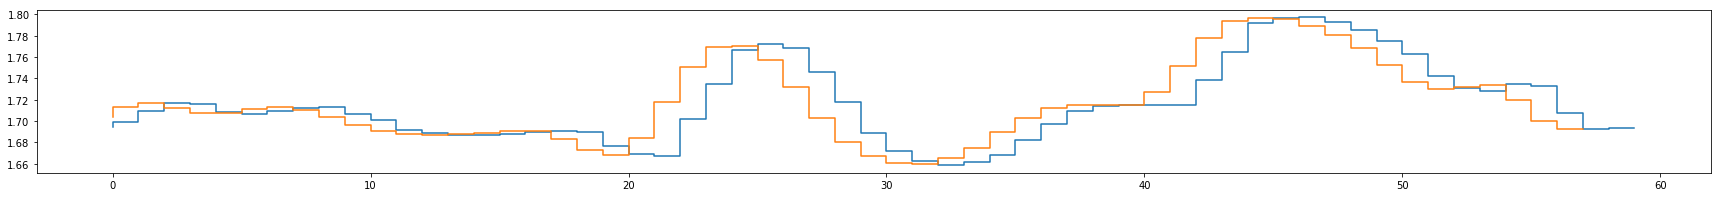

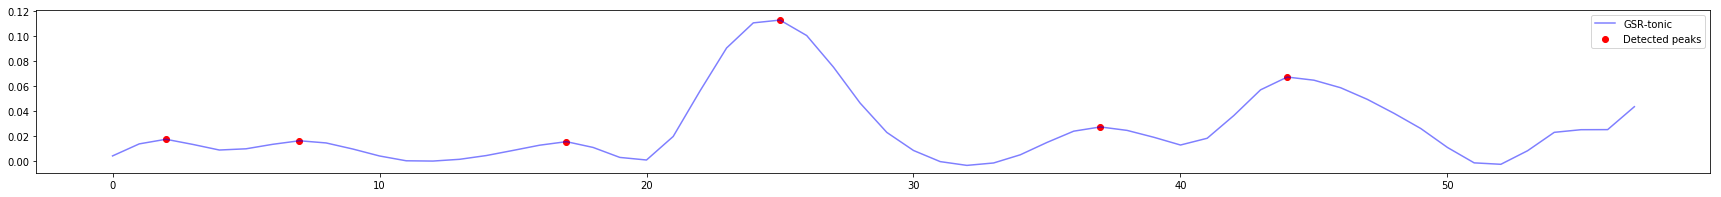

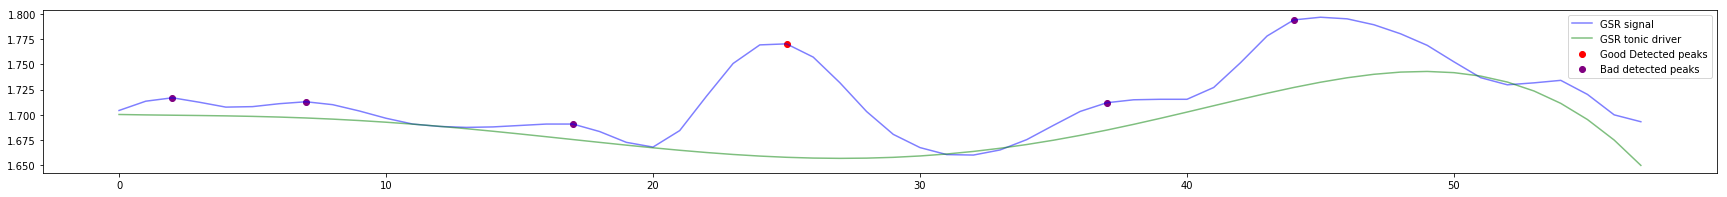

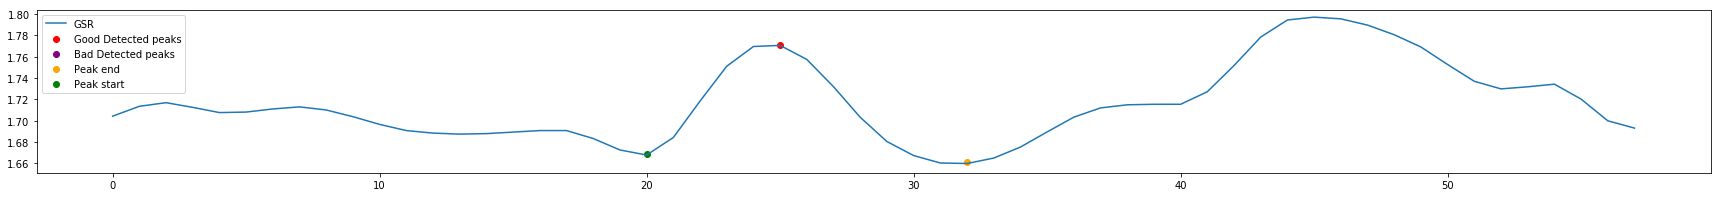

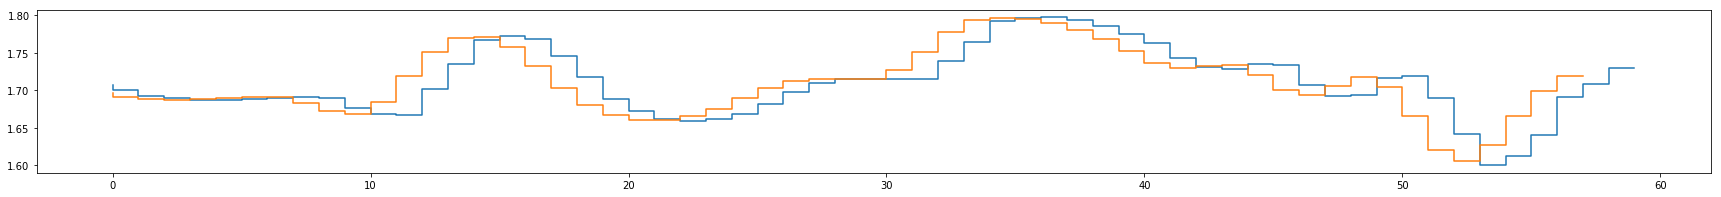

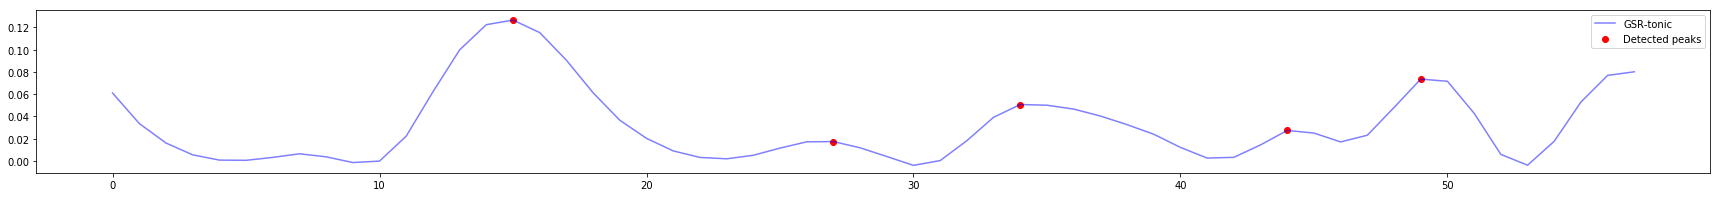

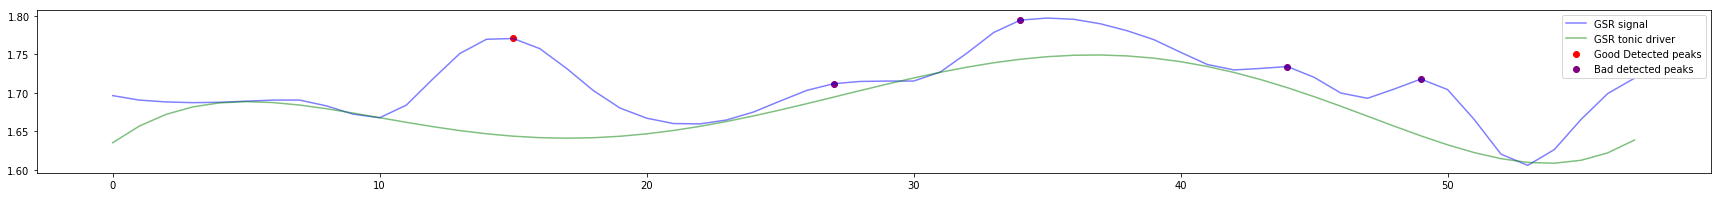

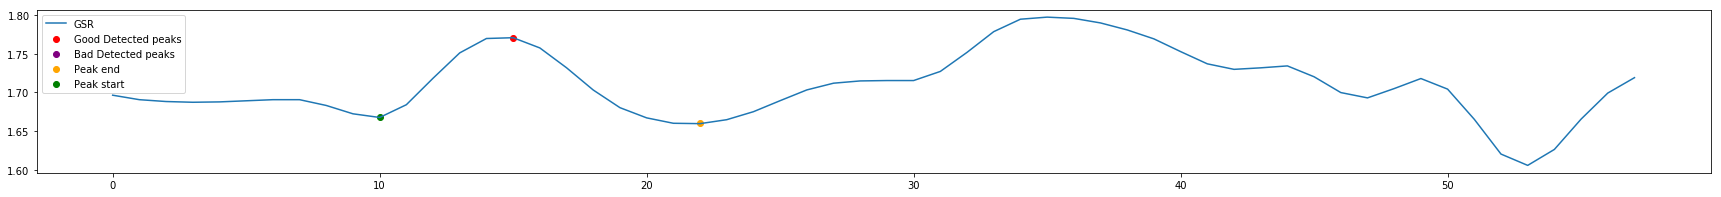

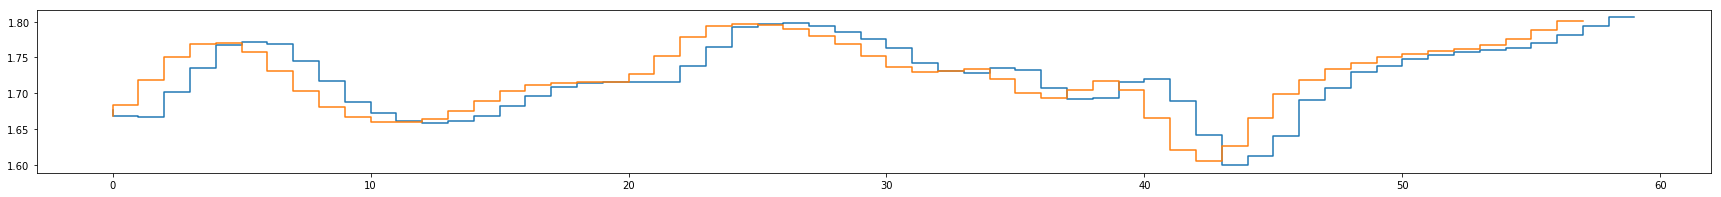

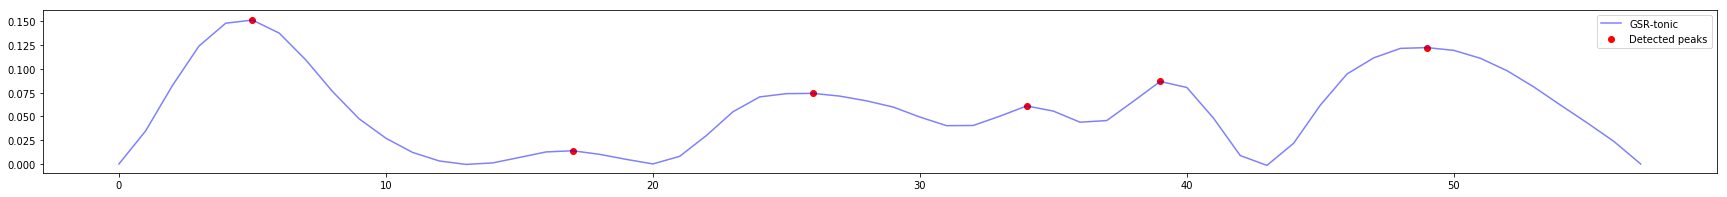

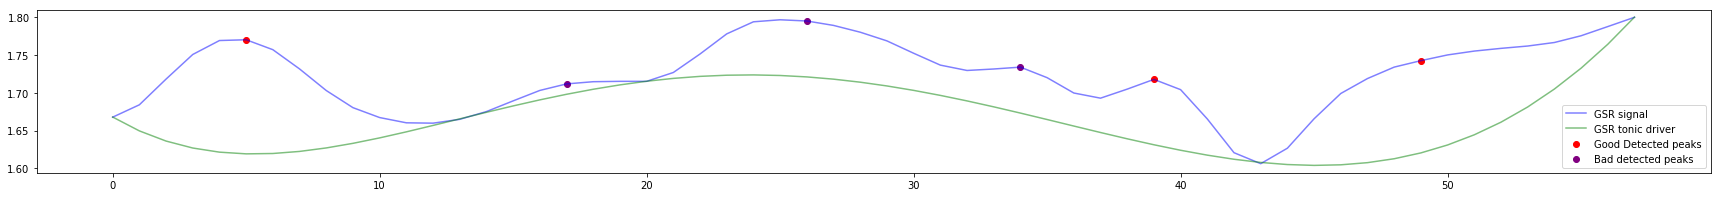

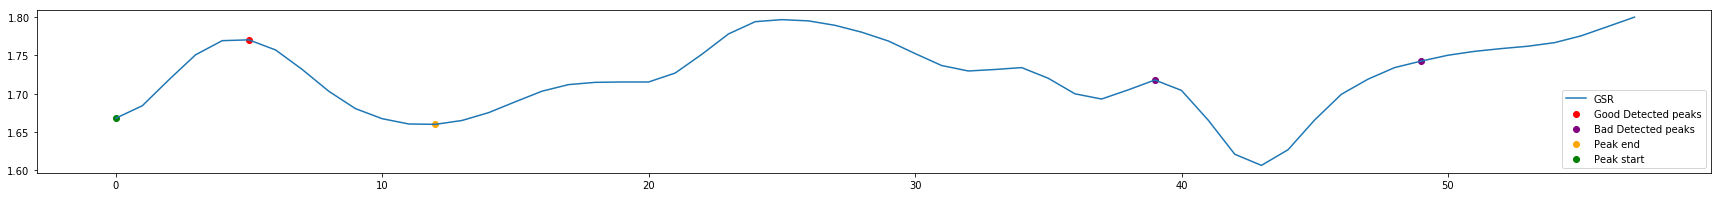

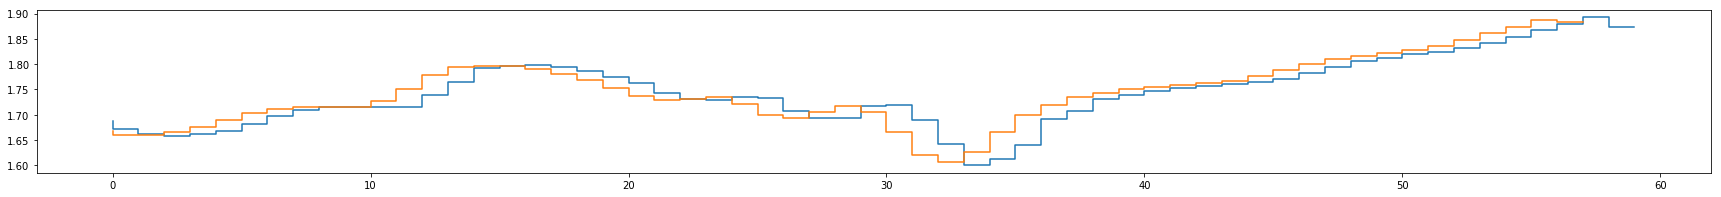

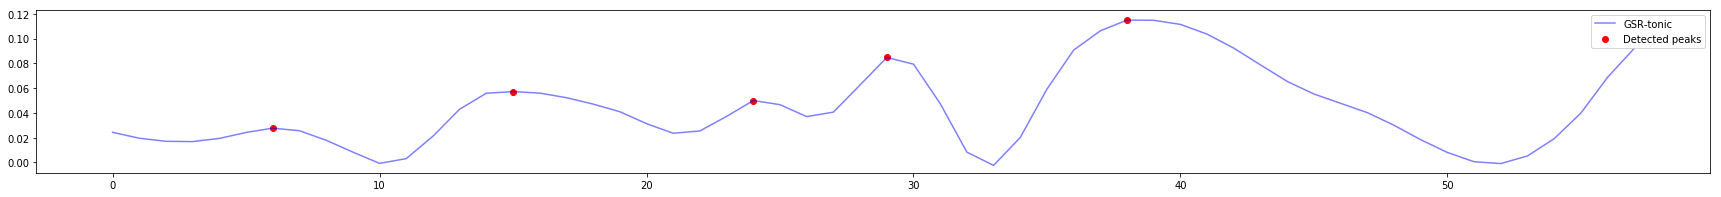

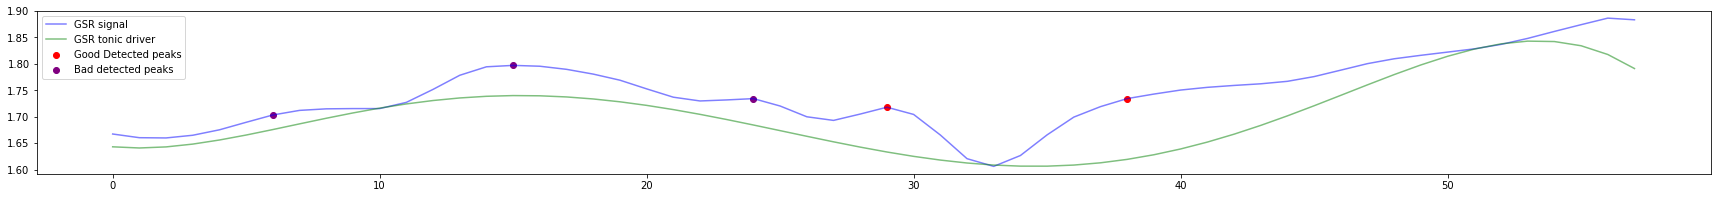

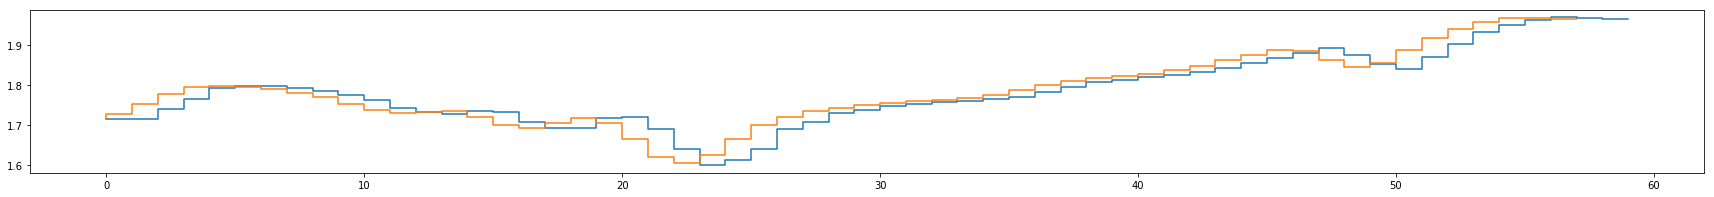

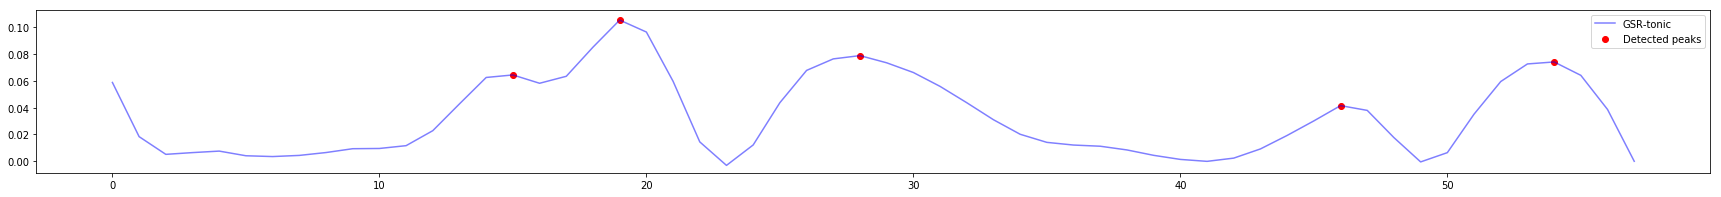

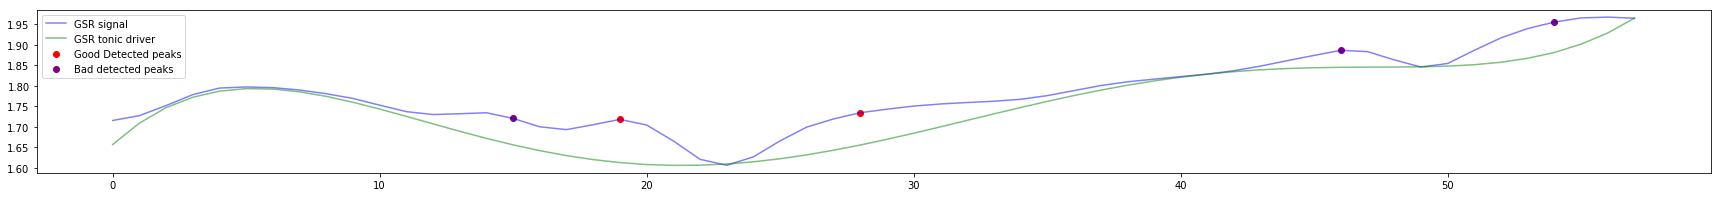

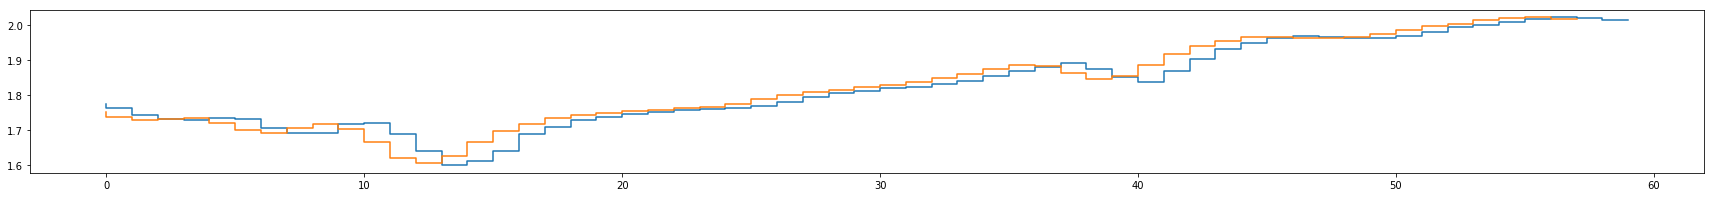

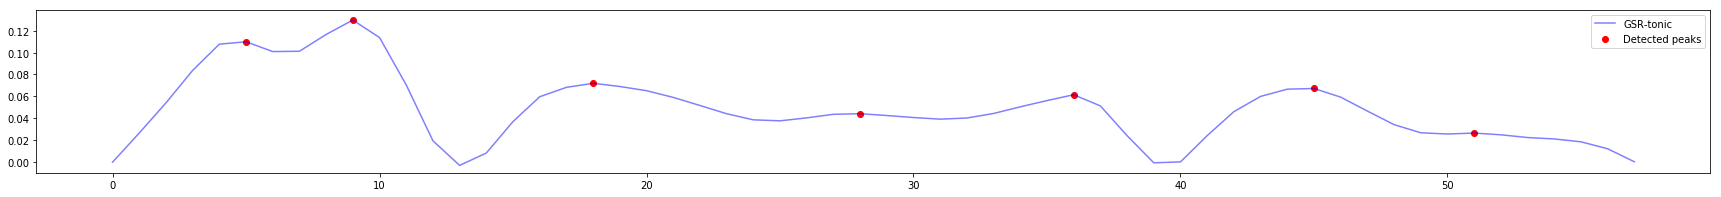

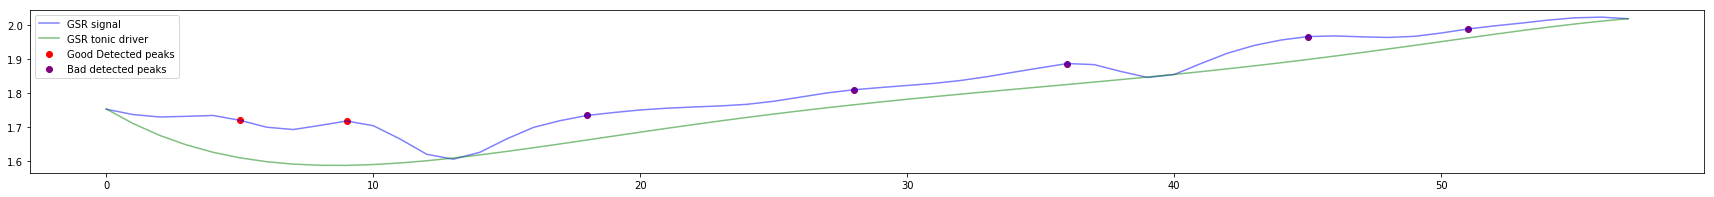

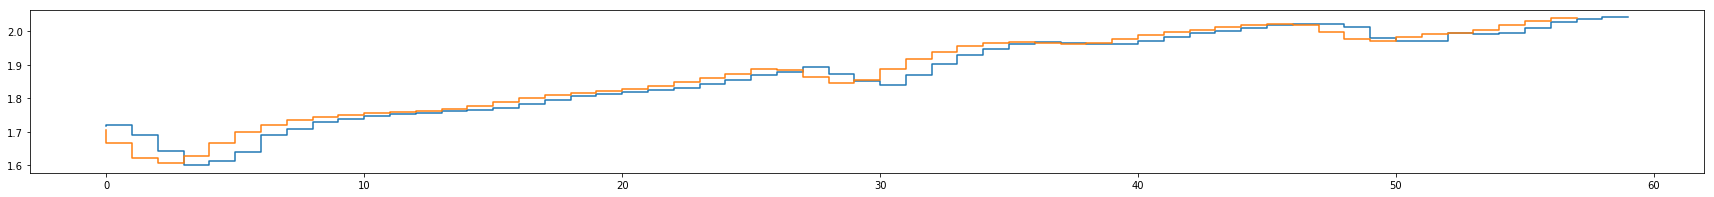

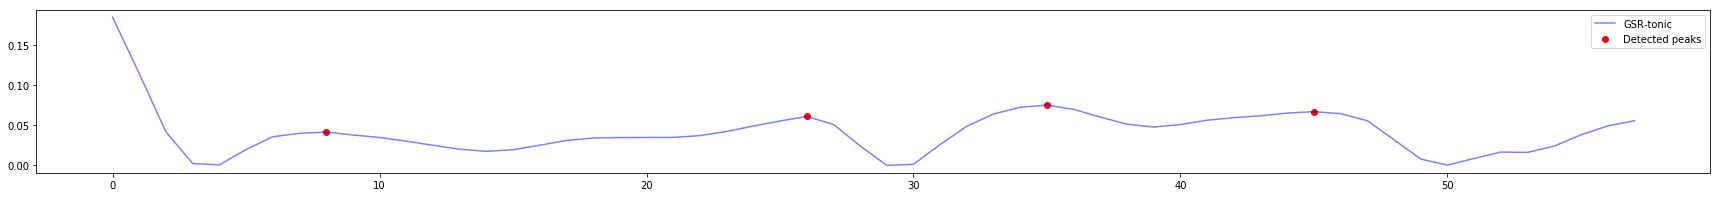

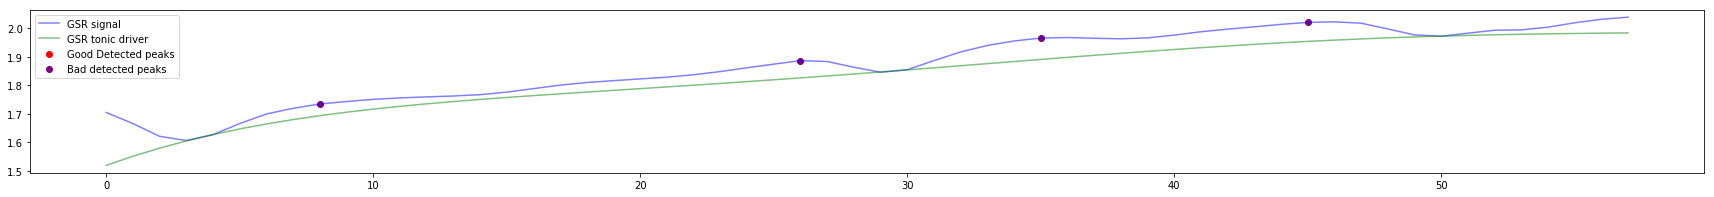

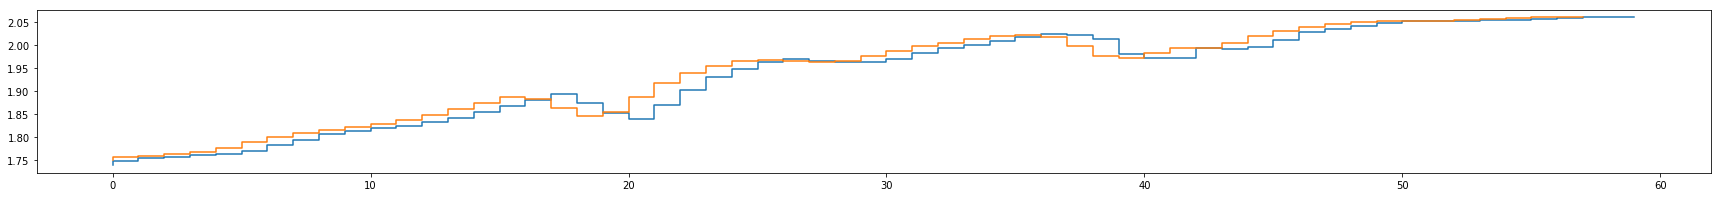

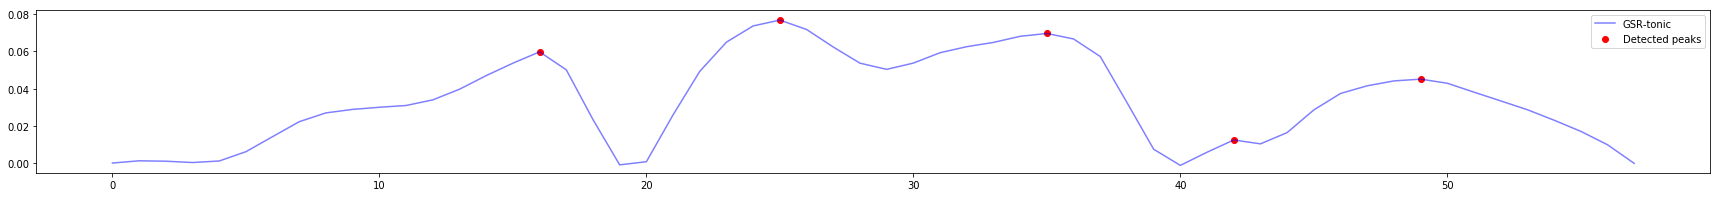

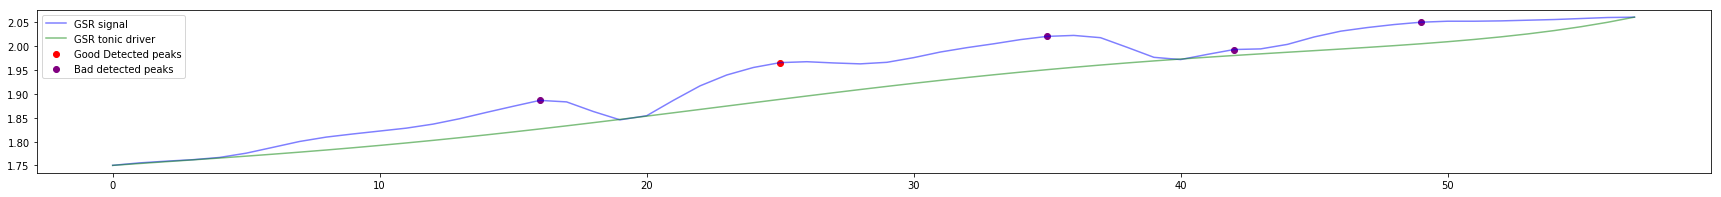

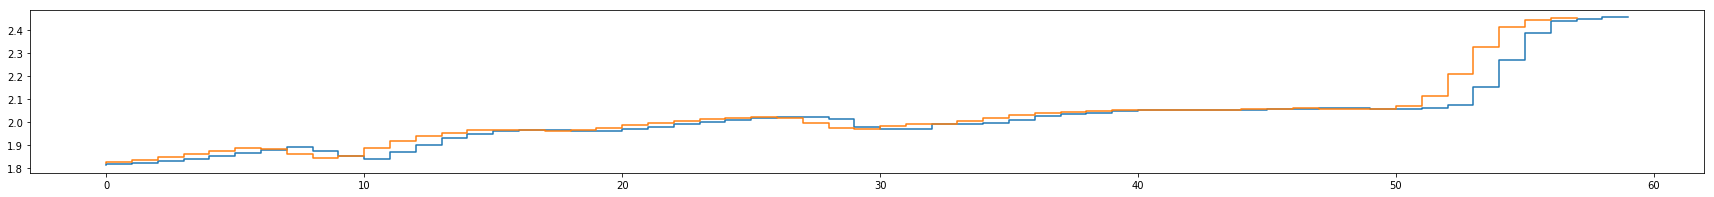

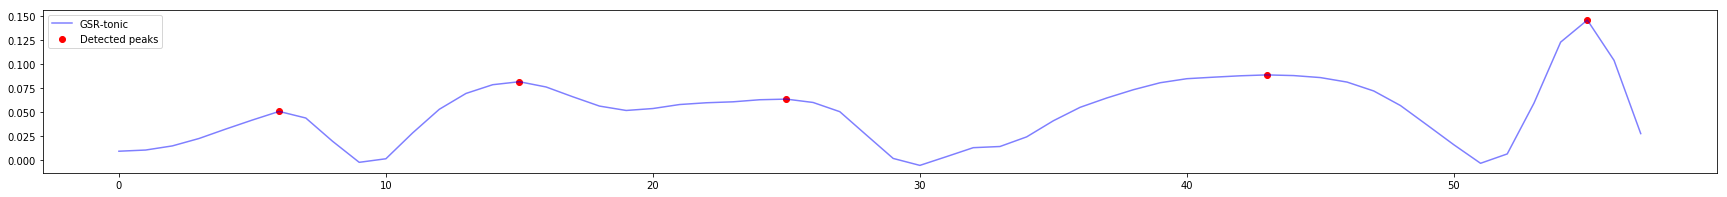

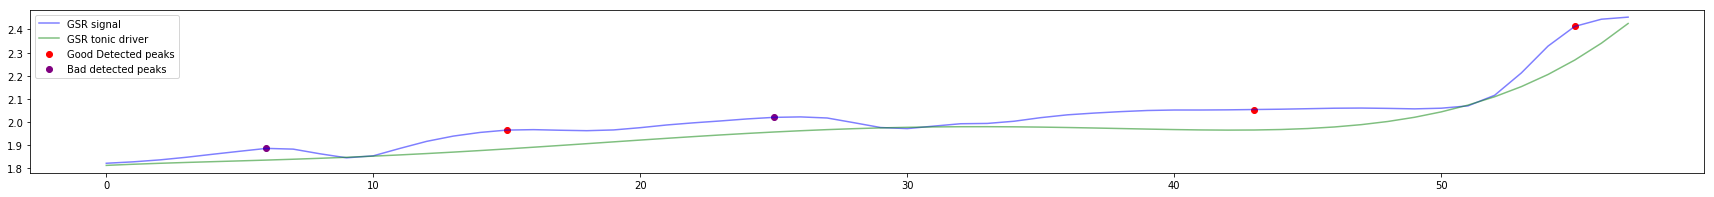

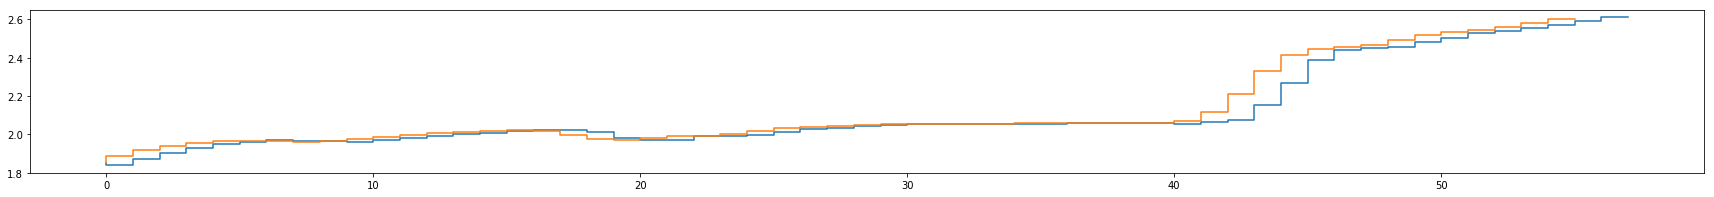

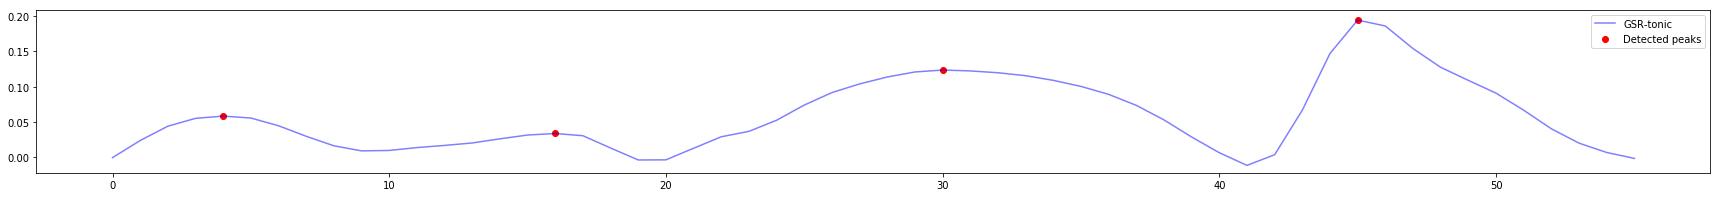

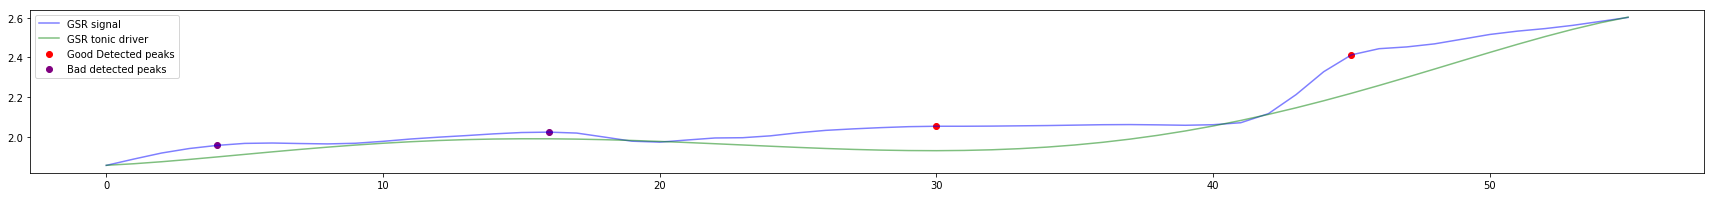

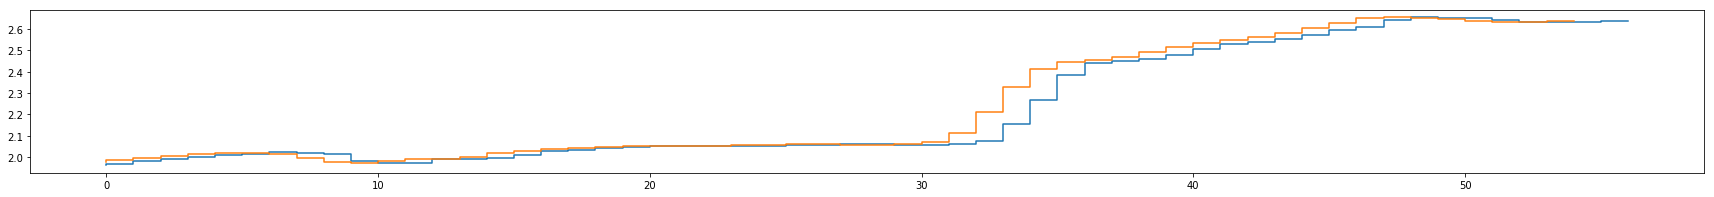

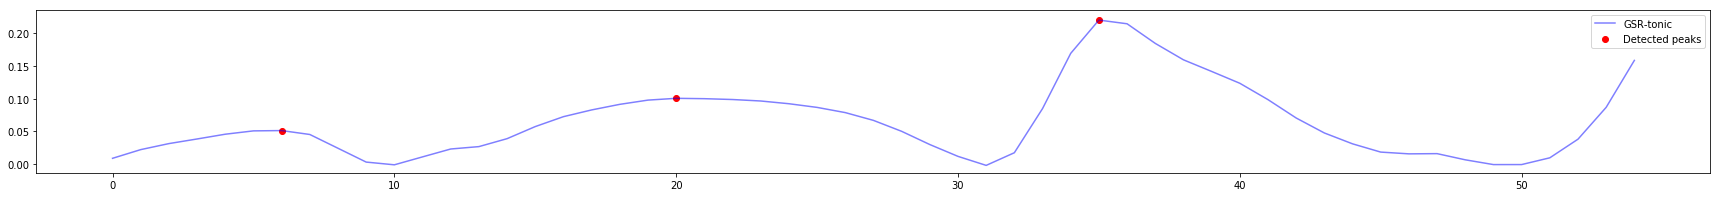

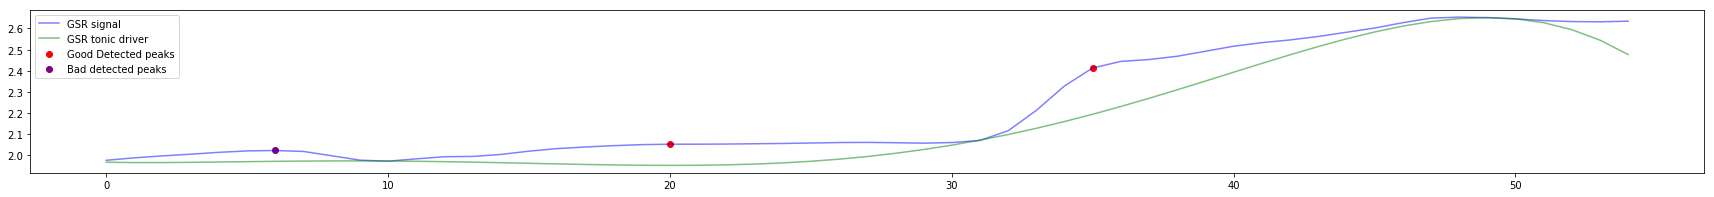

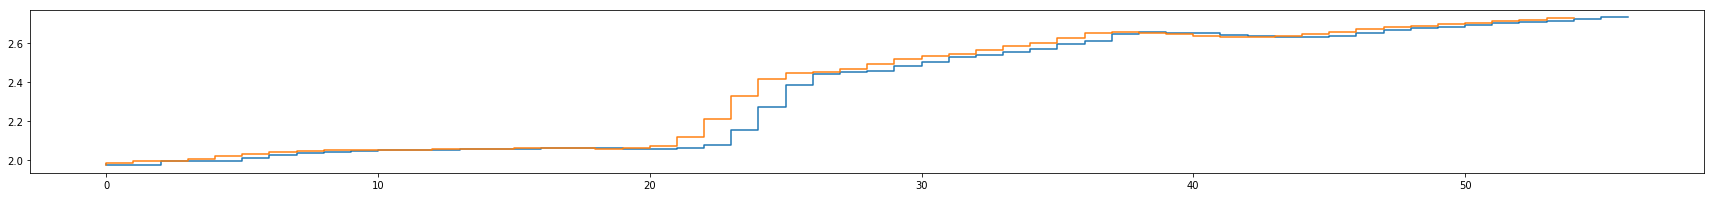

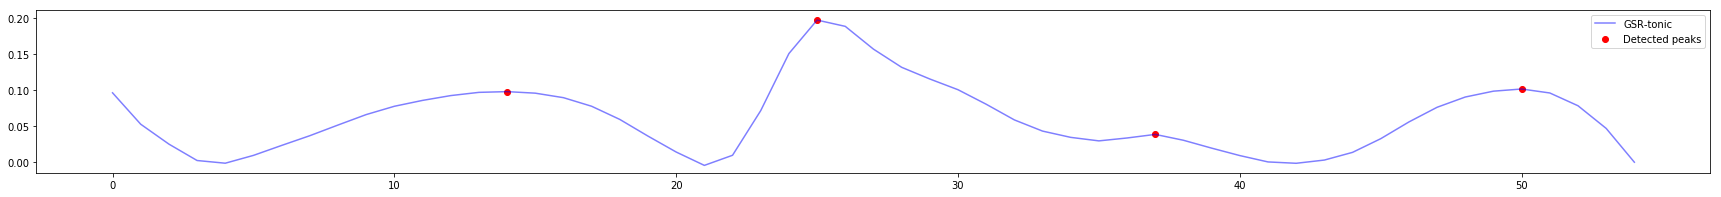

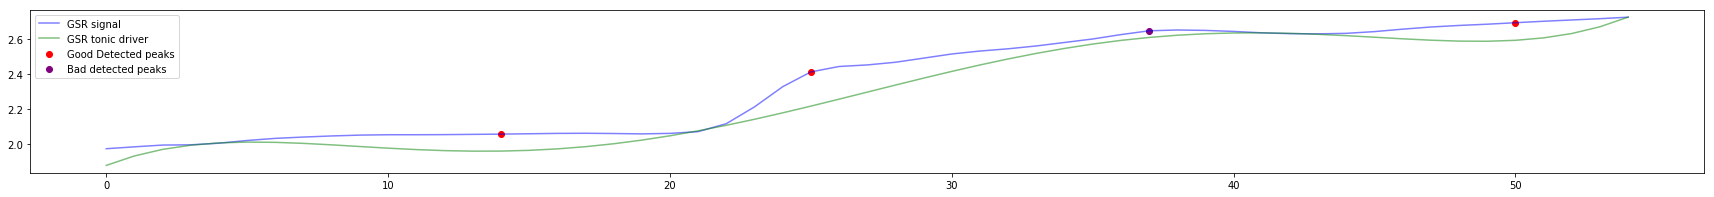

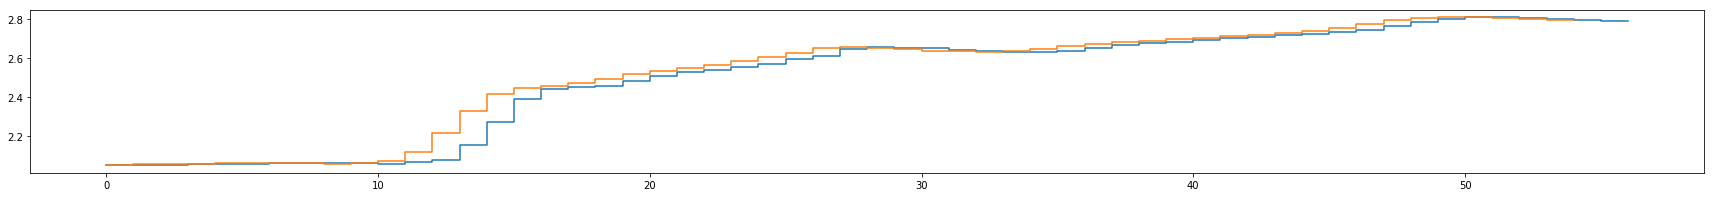

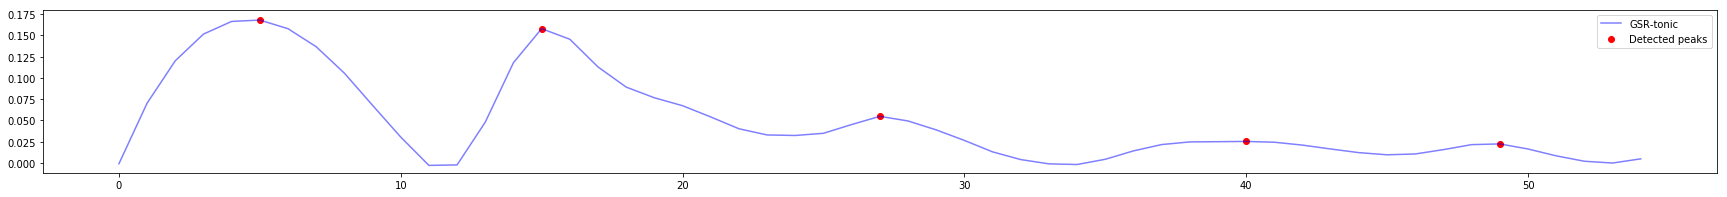

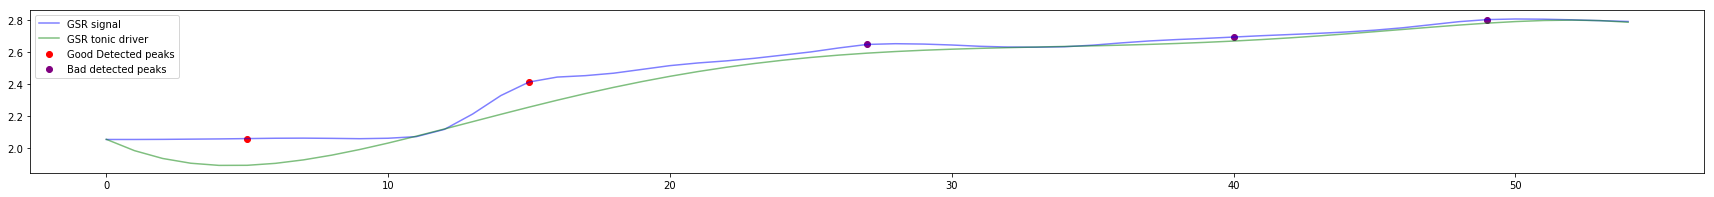

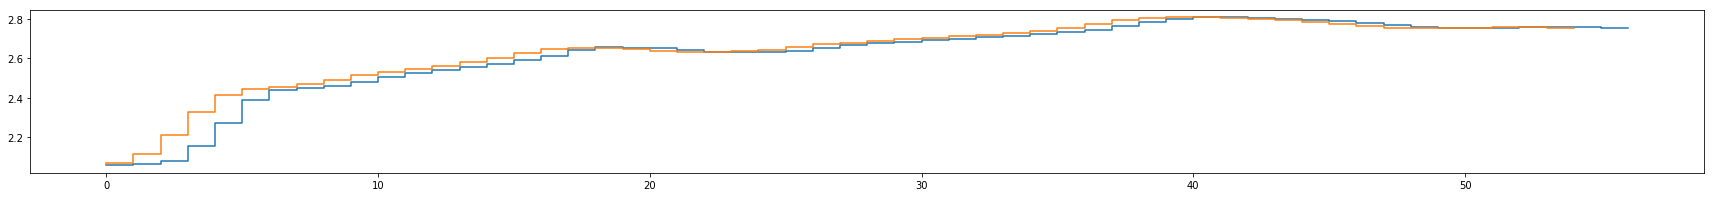

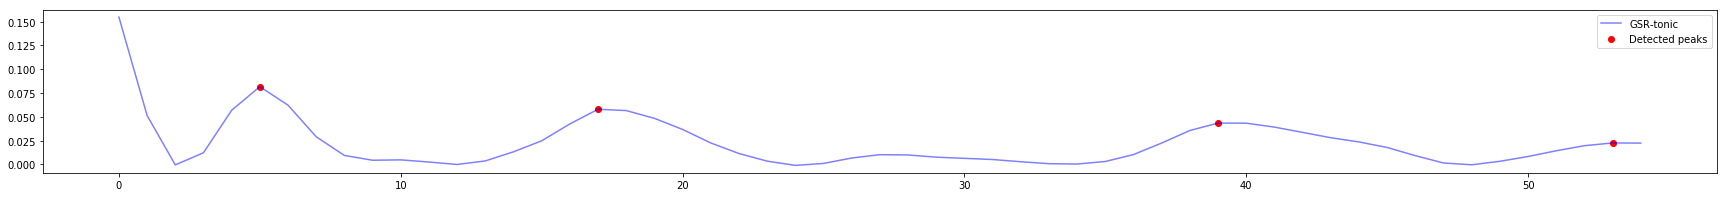

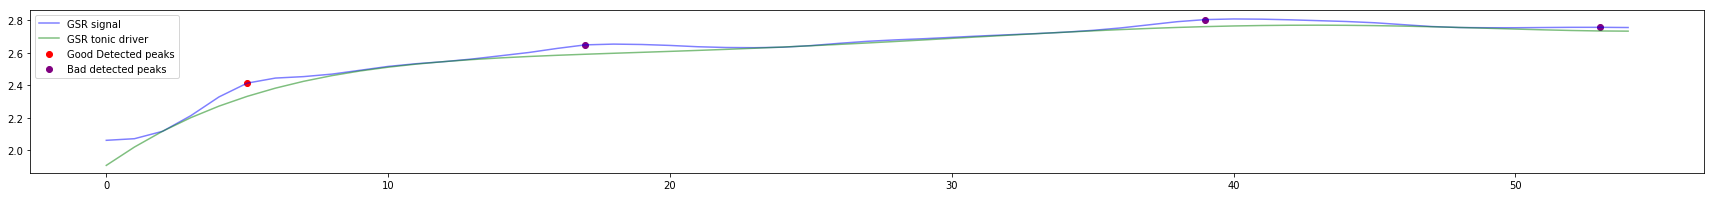

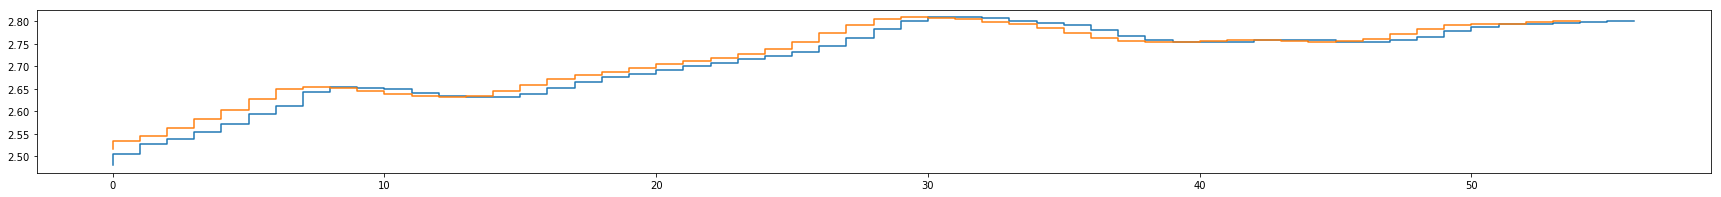

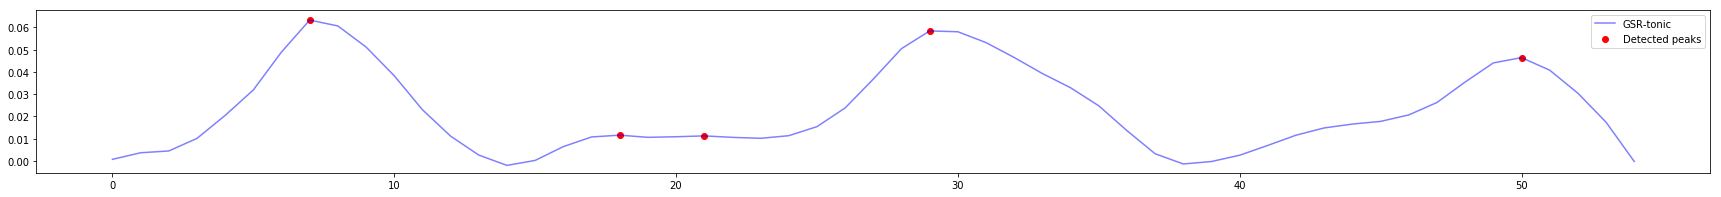

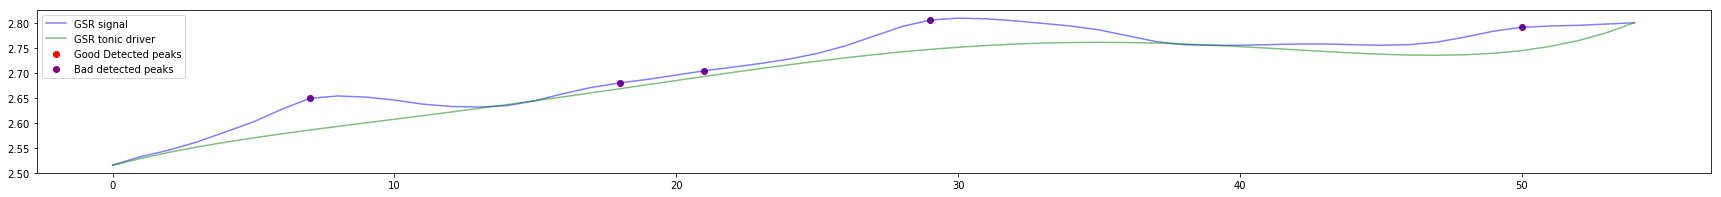

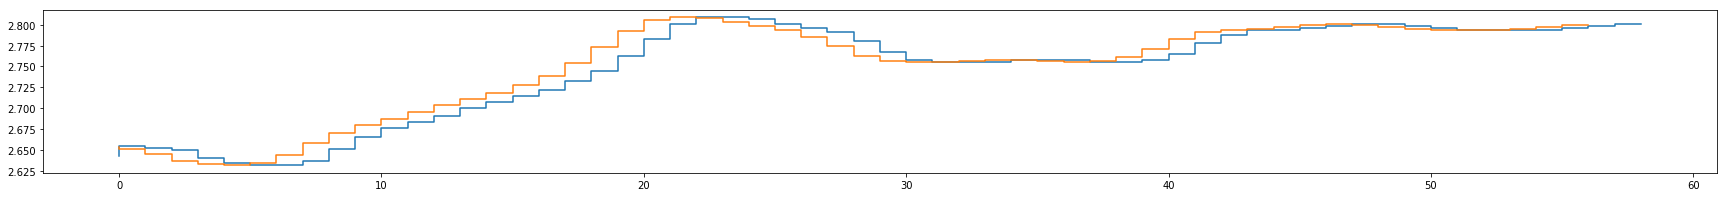

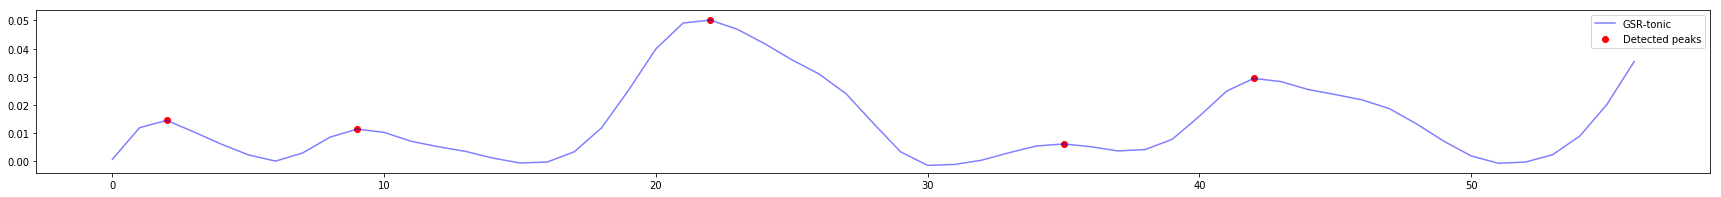

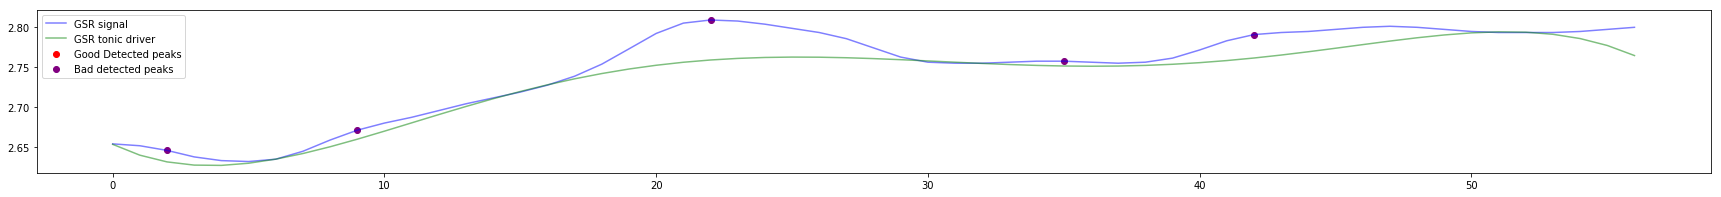

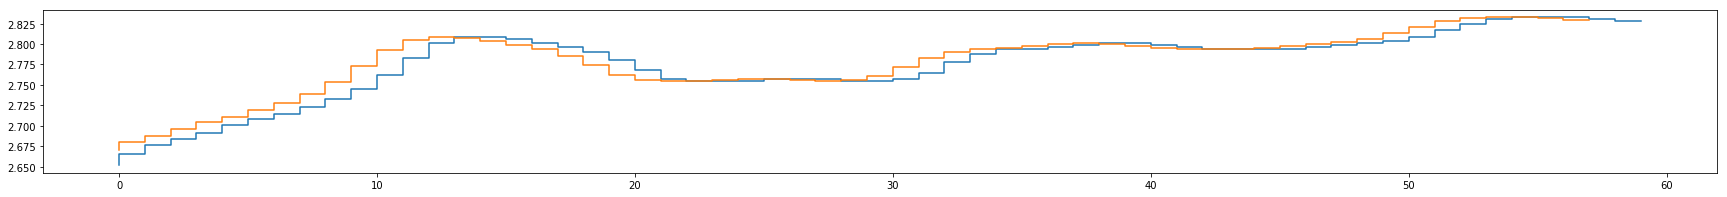

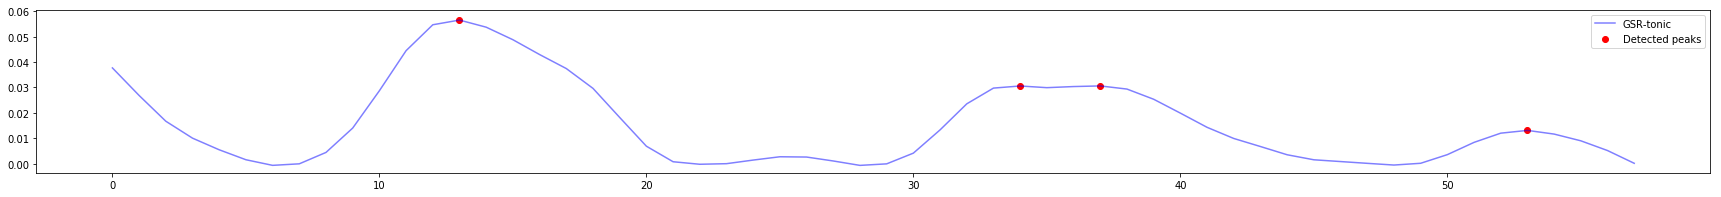

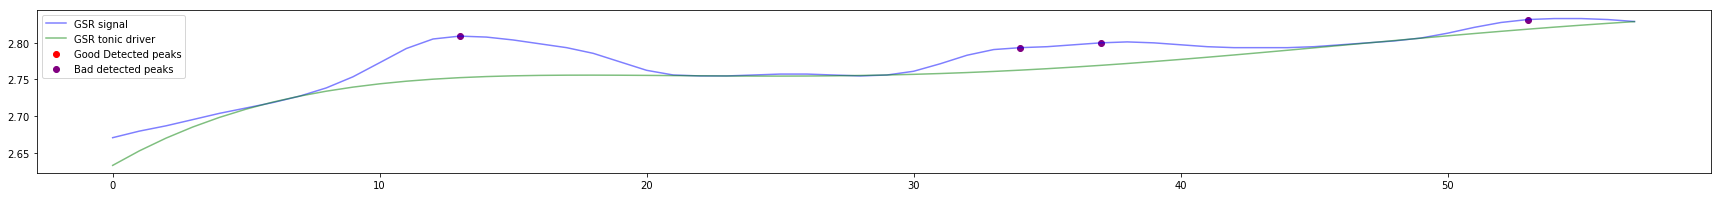

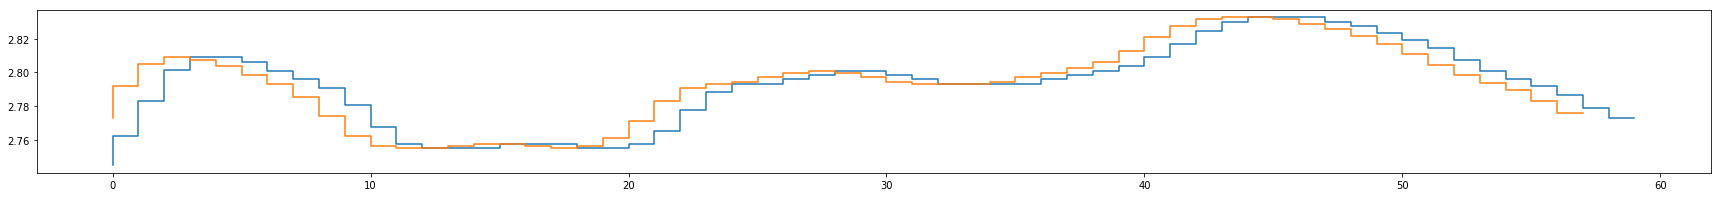

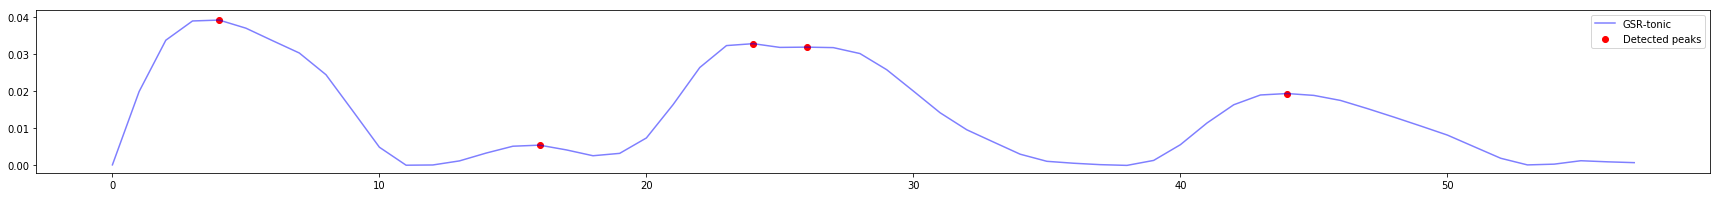

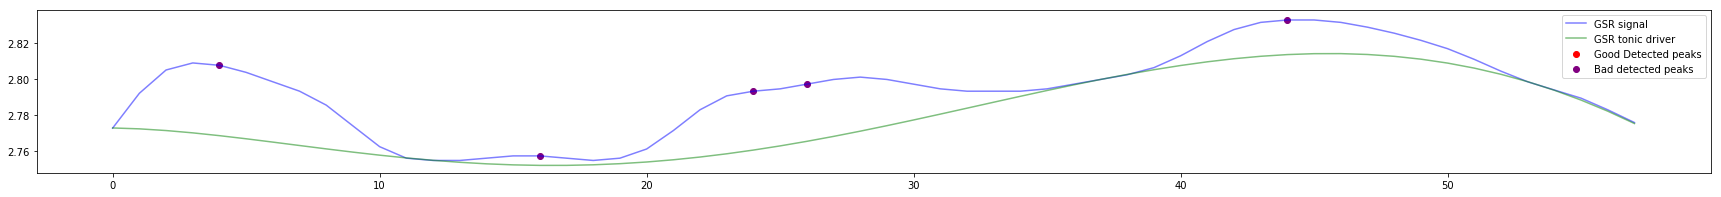

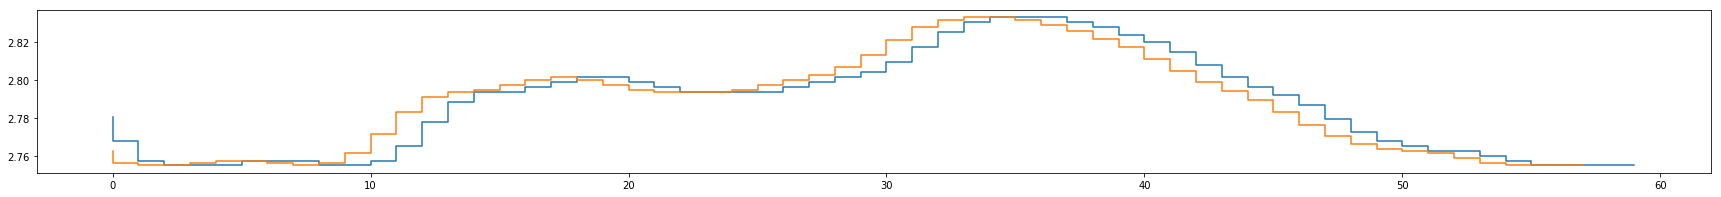

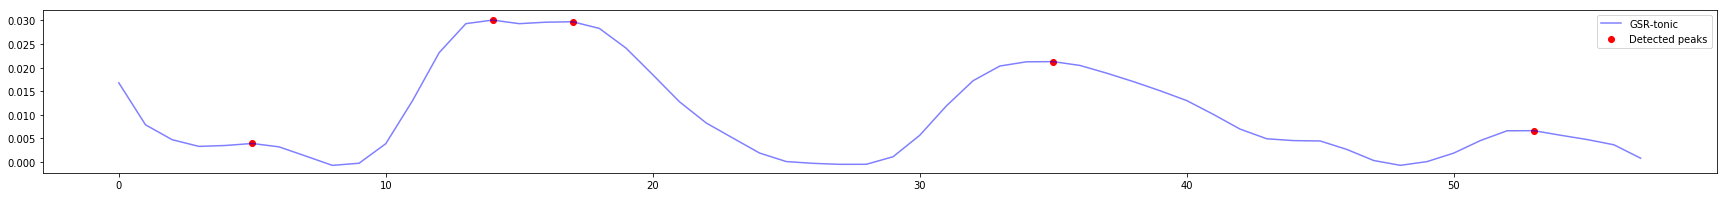

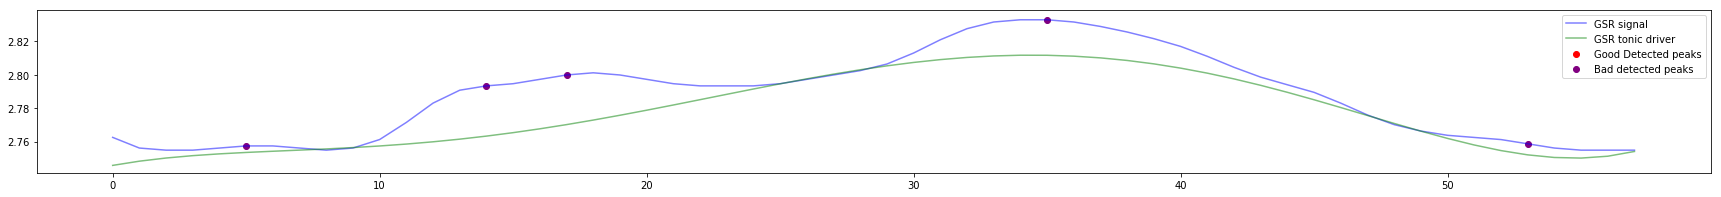

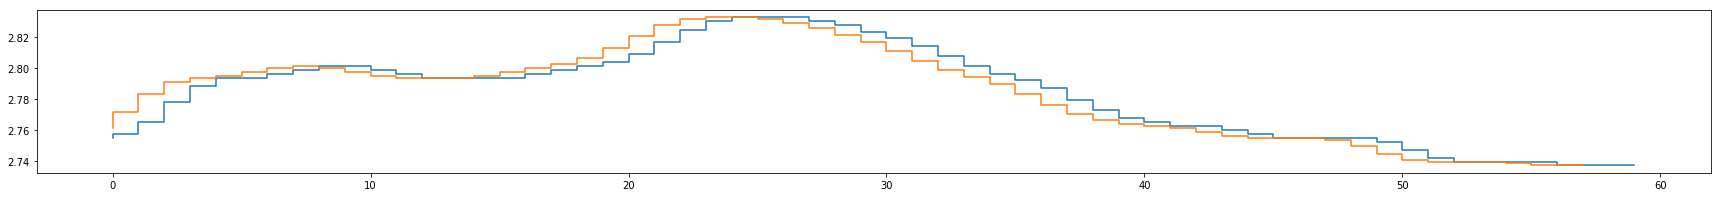

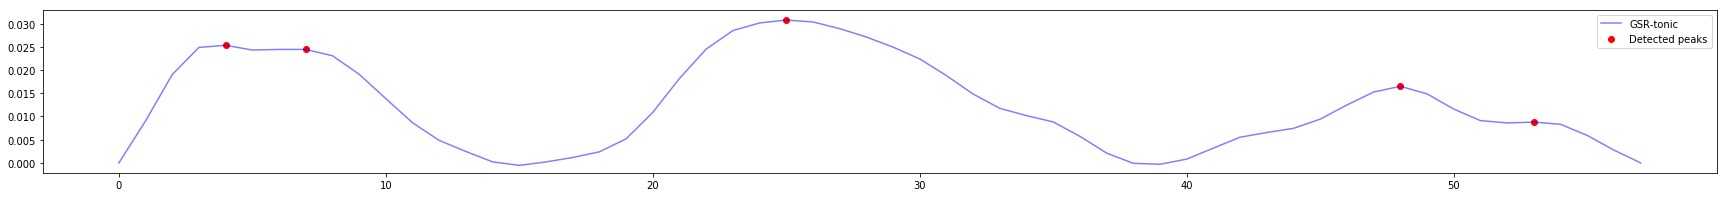

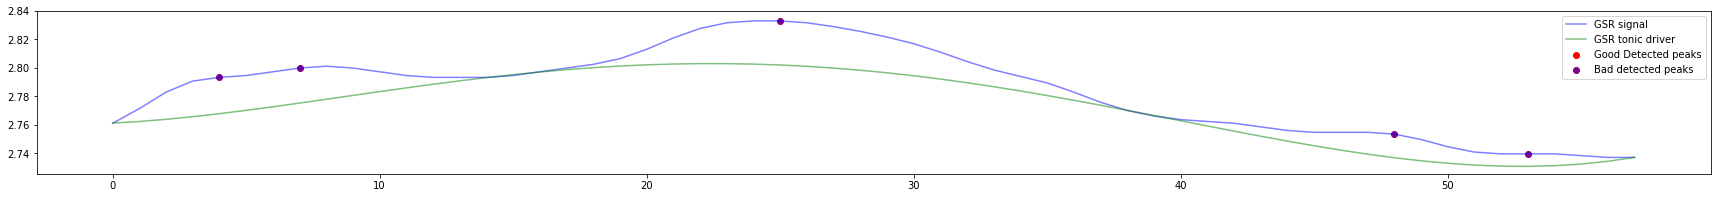

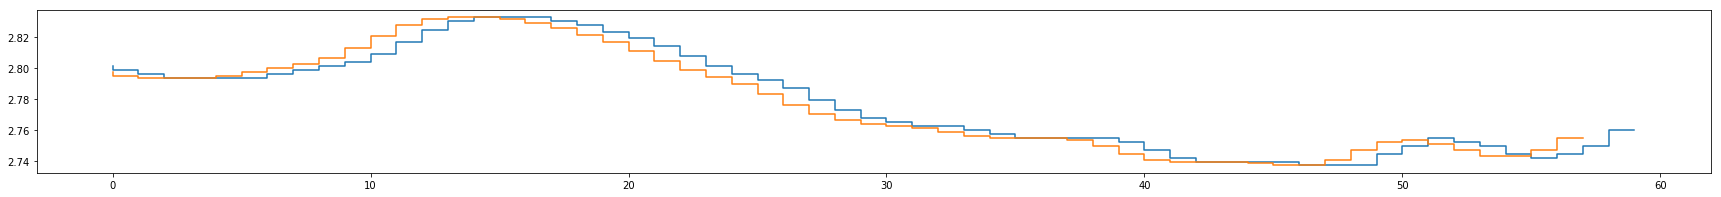

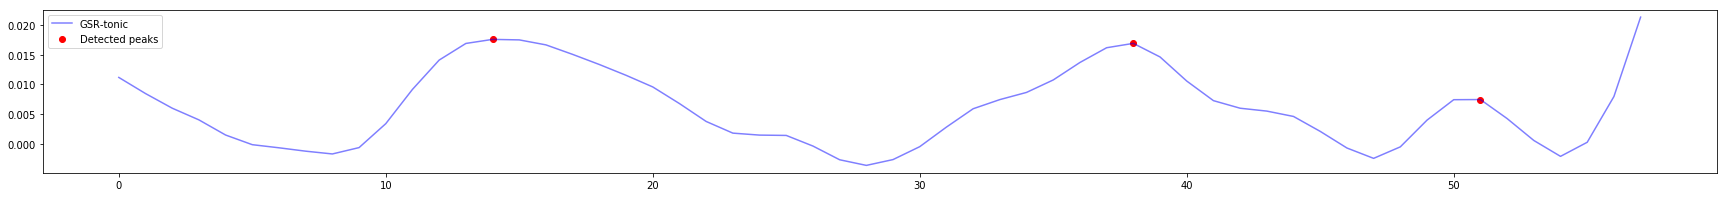

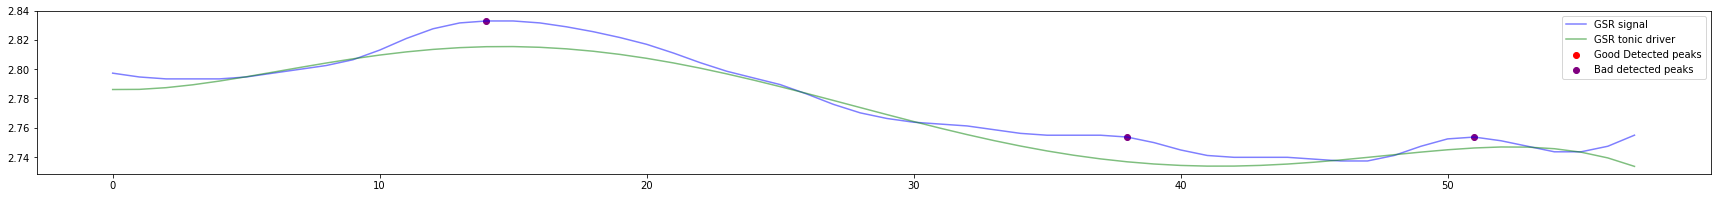

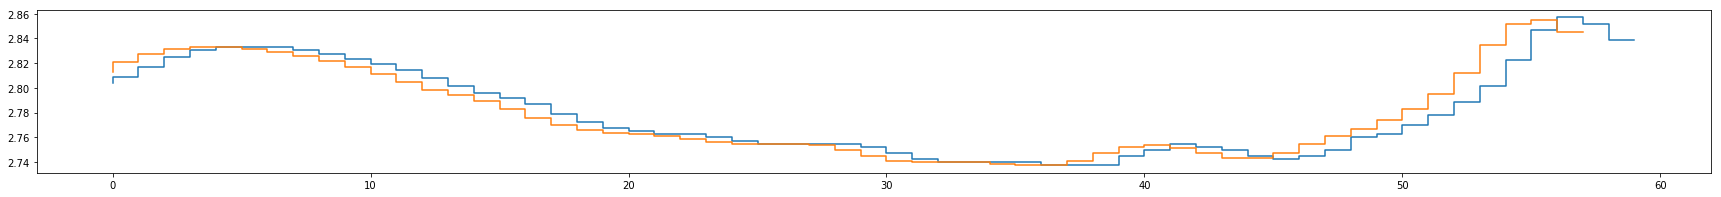

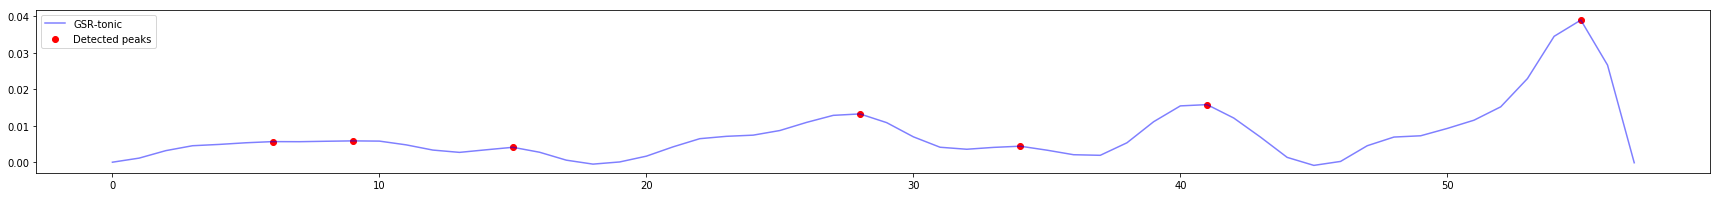

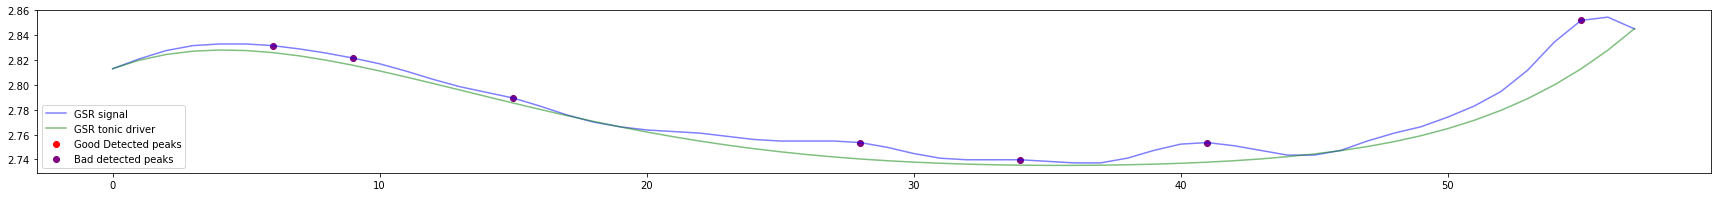

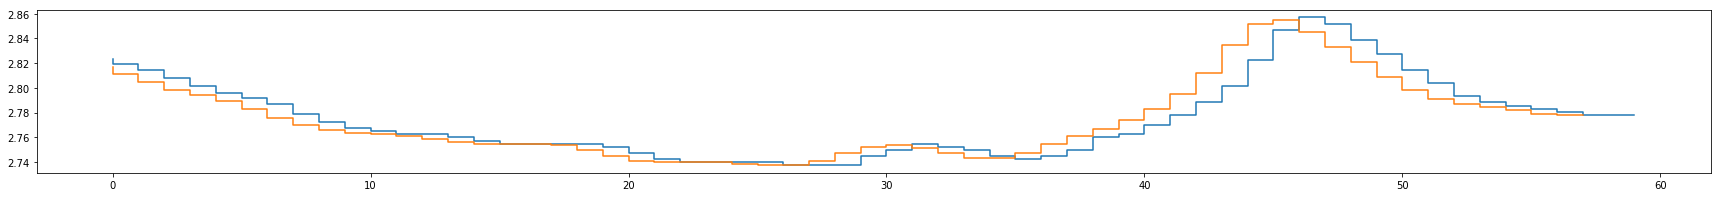

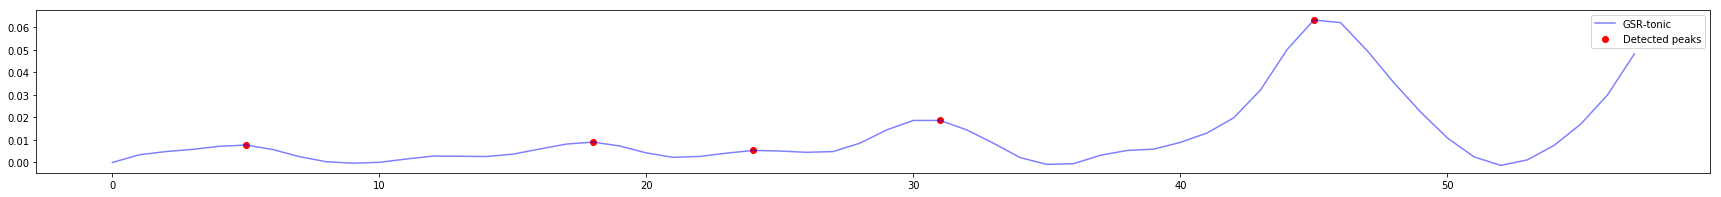

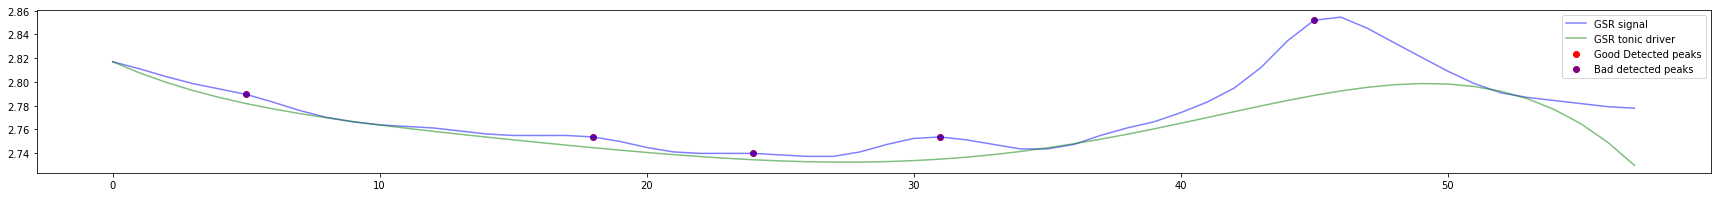

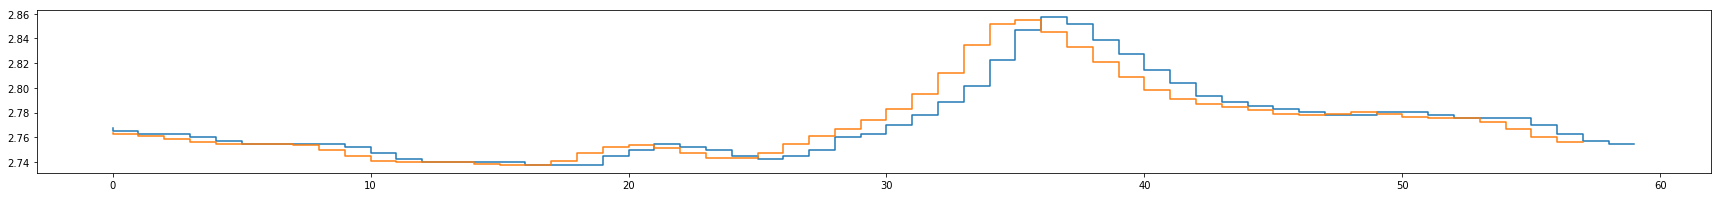

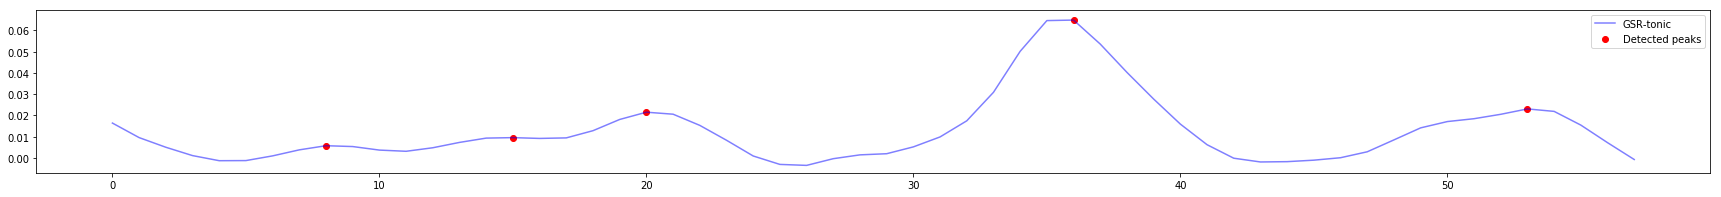

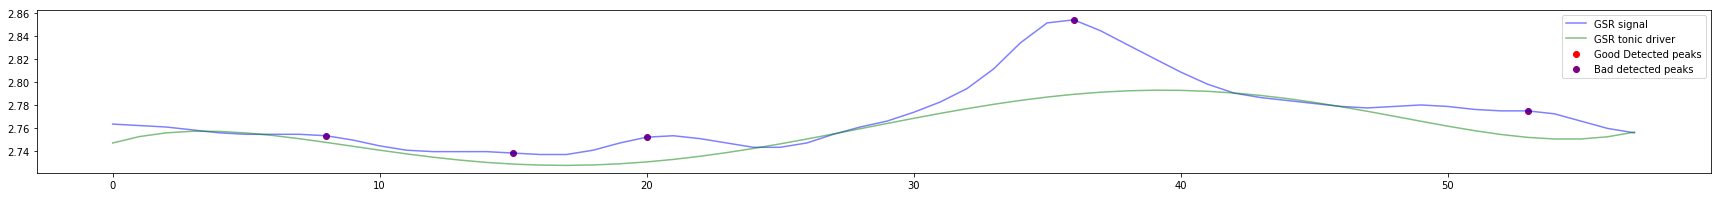

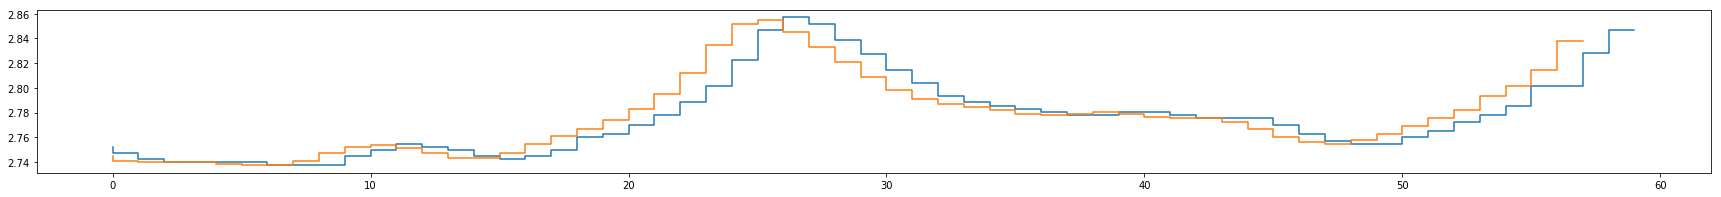

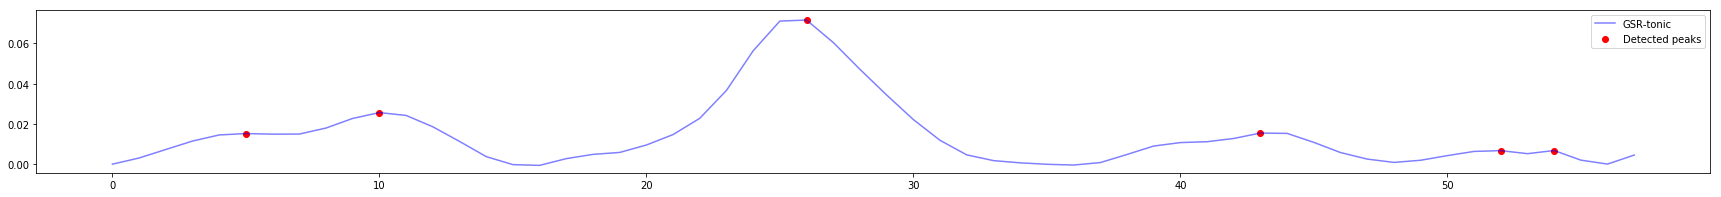

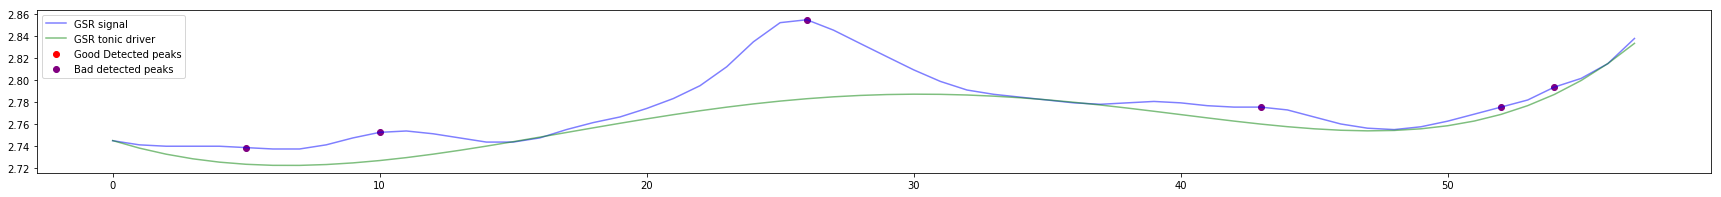

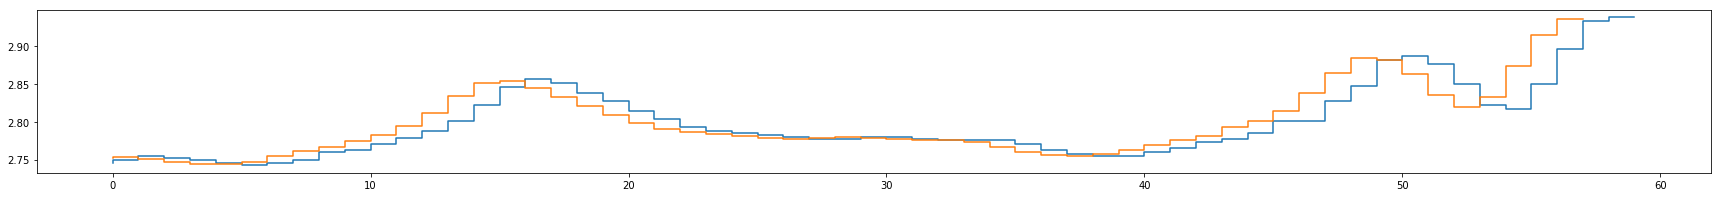

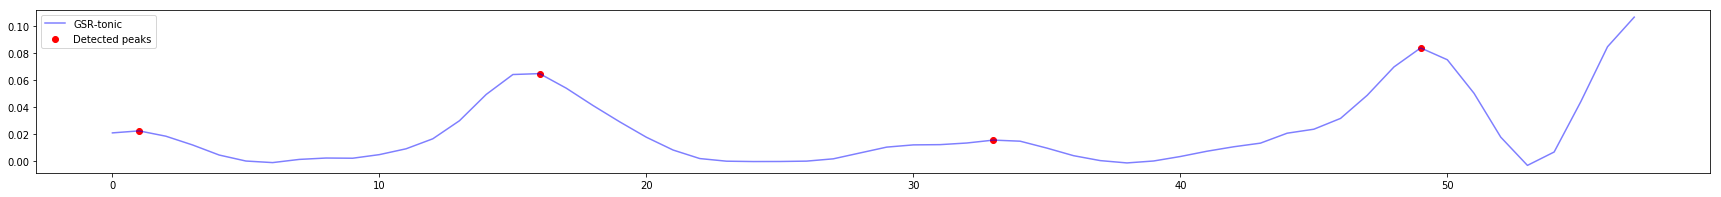

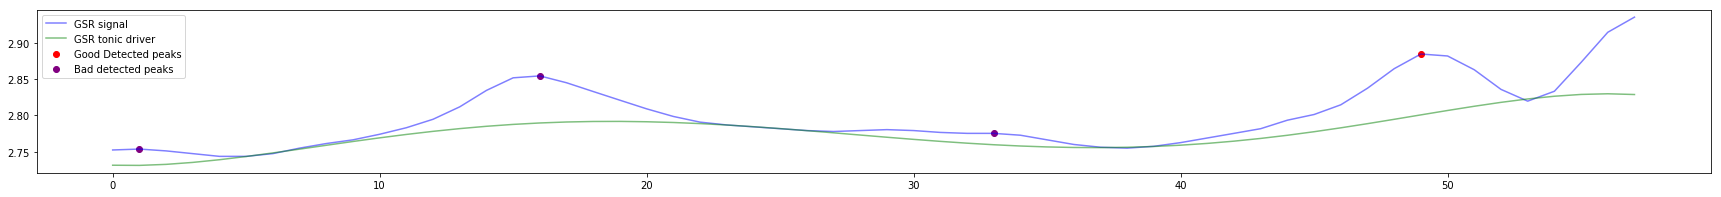

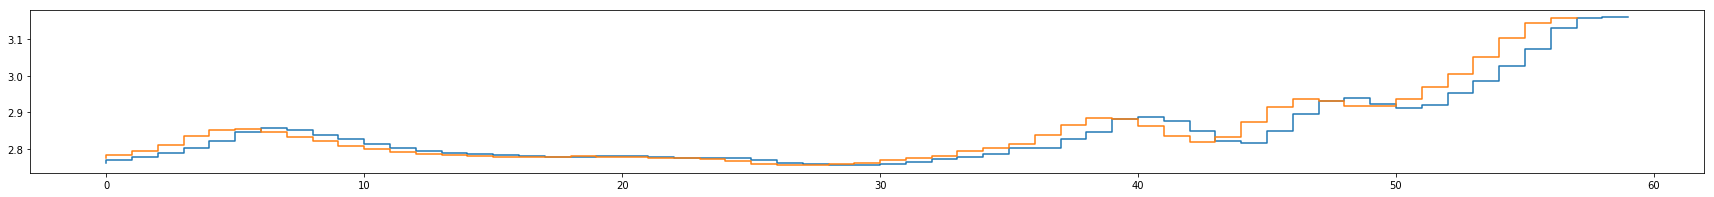

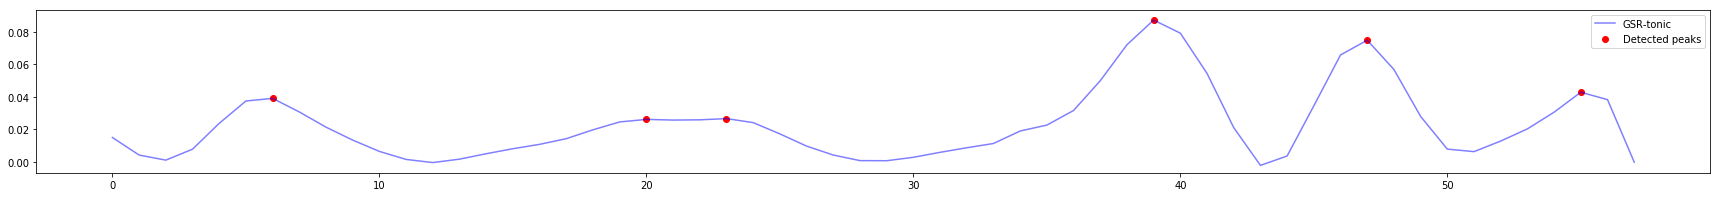

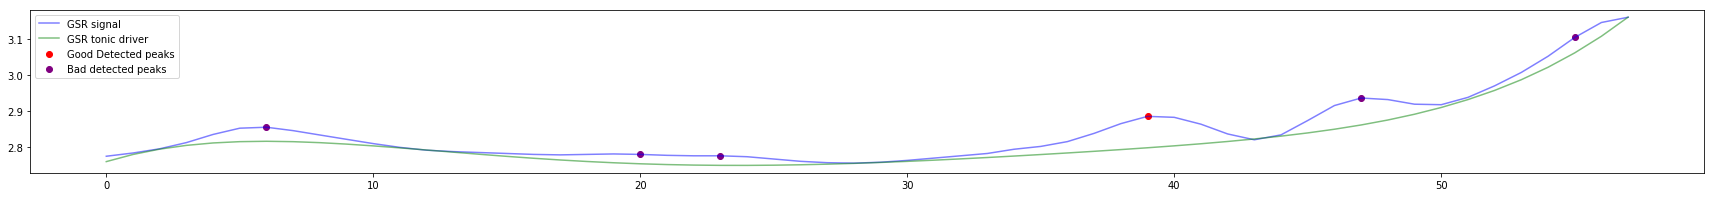

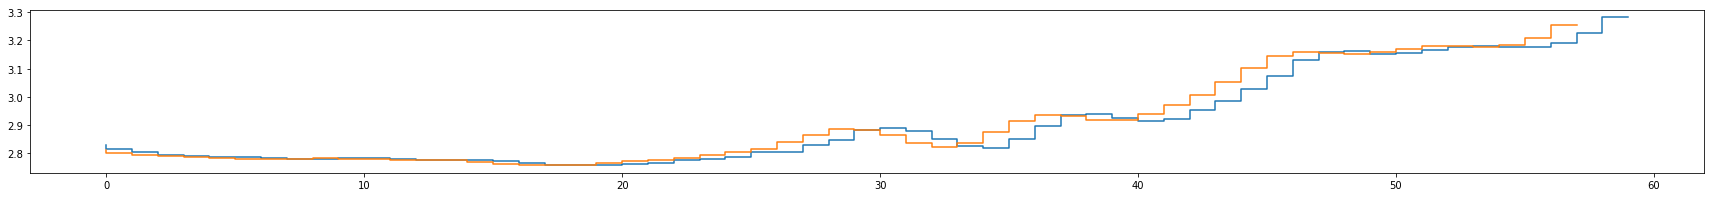

KeyboardInterrupt: 

In [6]:
#feature extraction functions
def get_stat_features_pd(arr):
    r = [arr.mean(),arr.std(),arr.skew(),arr.kurtosis(),arr.diff().mean(),
         arr.diff().diff().mean(),arr.quantile(0.25),arr.quantile(0.75),
         arr.quantile(0.75)-arr.quantile(0.25),arr.max()-arr.min()]
    if(arr.std()!=0):
        r.append(arr.mean()/arr.std())
    else:
         r.append(0.0)
    return np.hstack(r)

def get_stat_features_pd_all(arr):
    r = get_stat_features_pd(arr) #calculate statistical featues for the raw signal
    diff = arr.diff()
    diff.iloc[0] = diff.iloc[1]
    d = get_stat_features_pd(arr) #calculate statistical featues for the first derivative
        
    return np.hstack([r,d])

def extract_st_features(signal):
    f = get_stat_features_pd_all(pd.Series(signal))
    return f


def extract_hr_features(signal):

    signal = signal[~signal.isnull()] #moving average causes Nans for the first 10 samples (rolling size)
    f = get_stat_features_pd_all(pd.Series(signal))
    return f


def extract_eda_features(signal,sampling_rate=1,plt_flag=True):
#     signal = signal.rolling(10).mean()
    signal = signal[~signal.isnull()]
    f_sta = get_stat_features_pd_all(pd.Series(signal))
    if plt_flag:
        plt.figure(figsize=(30,3))
        plt.step(np.arange(len(signal)),signal,label='Original')
        moving_average_win_size = 2*sampling_rate #2 seconds
        signal = signal.rolling(moving_average_win_size).mean().iloc[moving_average_win_size:]
        plt.step(np.arange(len(signal)),signal,label='Original')
        plt.show()
    f = GSR.get_GSR_features(signal.values, sampling_rate, height_threshold=.075, plt_flag=plt_flag)
    return np.hstack([f_sta,f])

#calculate HRV features form the IBI signal
def extract_hrv_features_ibi(_rr,plt_flag=False):
#     print('extract_hrv_features_ibi',len(_rr))
    if plt_flag:
        plt.plot(_rr,label='Original rr')
    rr,outlier_indeces = HRV.hampel_filtering(_rr)
    timings = HRV.timestamps_from_RR(rr)

    timings_f,rr = HRV.medianFilter(timings,rr)
#     print('extract_hrv_features_ibi filtered',len(rr))
    if plt_flag:
        plt.plot(rr,label='Filtered rr')
        plt.legend()
        plt.show()
    if len(rr)>=15:
        hrv_time_features = HRV.HRV_time(rr,print_flag= plt_flag)
    else:
        hrv_time_features = np.array([-1]*len(HRV.feature_names_time)) #missing values: -1
  
    hrv_time_features = np.concatenate([hrv_time_features,[len(_rr)]])
                              
    return rr,hrv_time_features

#caclulate correlatio between eda and skin temeperature
def extract_correlation_features(signal_eda,signal_st):
    corr = pearsonr(signal_eda.values,signal_st.values)[0]
    return [corr]

def extract_features(df,sesison_id,info_columns):
    acc_freq = 1
    st_freq = 1
    eda_freq = 1

    window_slide = 10 *1000 #miliseconds
    window_size = 60 *1000#miliseconds

    #perform windowing using timestamps
    win_start = df.timestamp.iloc[0]
    file_end =df.timestamp.iloc[-1]
    win_end = win_start+window_size #seconds
    features_list = []
    while(win_end<=file_end):
#         try:
            #get window data
            window_data = df[(df.timestamp>=win_start) & (df.timestamp<=win_end)]
                        
#             print(window_data.shape)
            #extracct features
            st_f = extract_st_features(window_data.temperature)
            eda_f = extract_eda_features(window_data.gsr)
            hr_f = extract_hr_features(window_data.hr)
            rr,hrv_feats_ibi= extract_hrv_features_ibi(window_data.rr.values)
            corr_f = extract_correlation_features(window_data.gsr,window_data.temperature)

            info_ = [sesison_id,win_start,win_end]
            info_.extend(df[info_columns].mean())
#             print(info_,st_f.shape,eda_f.shape,hr_f.shape,hrv_feats_ibi.shape,len(corr_f))

            line = np.concatenate((info_,st_f,eda_f,hr_f,hrv_feats_ibi,corr_f))
            features_list.append(line)

            win_start = win_start+window_slide
            win_end = win_start+window_size
#         except Exception as e:
#             win_start = win_start+window_slide
#             win_end = win_start+window_size
#             print(e)

    return np.stack(features_list)
#list directories, perform windowing, feature extraction adn save to file
#expected format:
#09-20--->1568985147_A02920--->(ACC.csv,BVP.csv,...)
data_path = 'F:/Dropbox/CognitiveLoad/CogLoad1/raw/'
    
info_columns= ['TLX_mean', 'TLX_mental_demand', 'TLX_physical_demand',
       'TLX_temporal_demand', 'TLX_performance', 'TLX_effort','TLX_frustration', 
             'opacity_median','opacity_std']

    
for file in os.listdir(data_path):
    print('file:',file)
    df= pd.read_csv(data_path+file)
    features = extract_features(df,file,info_columns)
    column_names =  ['sesison_id','win_start','win_end']
    column_names.extend(info_columns)
    column_names.extend(feature_names)
    
    #convert timestamps to dateTime and conert to Slovenian Timezone
    df = pd.DataFrame(features,columns=column_names)
    df['dateTime_start']= pd.to_datetime(df.win_start,unit ='ms').dt.tz_localize('UTC').dt.tz_convert('Europe/Brussels').dt.strftime('%Y-%m-%d %H:%M:%S')
    df['dateTime_end']= pd.to_datetime(df.win_end,unit ='ms').dt.tz_localize('UTC').dt.tz_convert('Europe/Brussels').dt.strftime('%Y-%m-%d %H:%M:%S')
    #swap columns
    new_columns = [df.columns[0]]
    new_columns.extend(df.columns[-2:])
    new_columns.extend(df.columns[1:-2])
    df = df[new_columns]
    features_save_path = 'F:/Cognitive_Load_Competition/Cog_Load/features_'+file
    df.to_csv(features_save_path)